**By Shreya**

# --- 1. Install & Import Libraries ---
# Run once if not already installed:
# !pip install geopandas pandas matplotlib seaborn libpysal esda splot spreg statsmodels

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Queen, lag_spatial
from esda import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from spreg import OLS, ML_Lag, ML_Error
from statsmodels.api import Logit
from scipy.stats import fisher_exact

# --- 2. Load Data ---
# Adjust file paths accordingly
shapefile_path = "C:\Users\Rhitwik\Downloads\US_States\US_States\US_STATES.shp"
csv_path = "C:\Users\Rhitwik\Downloads\Manipulated_Final_Results.csv"

gdf = gpd.read_file(shapefile_path)
df = pd.read_csv(csv_path)

# Merge shapefile with CSV data on state name
gdf = gdf.merge(df, left_on="NAME", right_on="STATE_NAME")

# --- 3. Clean & Standardize ---
# Standardize internet and social media usage
gdf["internet_z"] = (gdf["Internet_Usage_P"] - gdf["Internet_Usage_P"].mean()) / gdf["Internet_Usage_P"].std()
gdf["social_z"] = (gdf["Social_Media_Usage_P"] - gdf["Social_Media_Usage_P"].mean()) / gdf["Social_Media_Usage_P"].std()

# Drop rows with NA in the z-score columns
gdf_clean = gdf.dropna(subset=["internet_z", "social_z"]).copy()

# --- 4. Spatial Weights ---
w = Queen.from_dataframe(gdf_clean)
w.transform = 'r'

# --- 5. Global Moran's I ---
moran_internet = Moran(gdf_clean["internet_z"], w)
moran_social = Moran(gdf_clean["social_z"], w)

print("Moran's I - Internet Usage:", moran_internet.I, "p-value:", moran_internet.p_sim)
print("Moran's I - Social Media Usage:", moran_social.I, "p-value:", moran_social.p_sim)

# --- 6. LISA (Local Moran's I) ---
lisa_internet = Moran_Local(gdf_clean["internet_z"], w)
lisa_social = Moran_Local(gdf_clean["social_z"], w)

# --- 7. Classify LISA Clusters ---
def classify_lisa(gdf, var, lisa, var_mean):
    cluster = []
    for i in range(len(gdf)):
        if lisa.p_sim[i] < 0.05:
            if gdf[var].iloc[i] > var_mean and lisa.Is[i] > 0:
                cluster.append("High-High")
            elif gdf[var].iloc[i] < var_mean and lisa.Is[i] > 0:
                cluster.append("Low-Low")
            elif gdf[var].iloc[i] > var_mean and lisa.Is[i] < 0:
                cluster.append("High-Low")
            elif gdf[var].iloc[i] < var_mean and lisa.Is[i] < 0:
                cluster.append("Low-High")
            else:
                cluster.append("Not Significant")
        else:
            cluster.append("Not Significant")
    return cluster

gdf_clean["cluster_internet"] = classify_lisa(gdf_clean, "internet_z", lisa_internet, gdf_clean["internet_z"].mean())
gdf_clean["cluster_social"] = classify_lisa(gdf_clean, "social_z", lisa_social, gdf_clean["social_z"].mean())

# --- 8. Improved LISA Maps (Bigger, Clearer, Separate) ---

# Define a clearer color palette
cluster_palette = {
    "High-High": "red",
    "Low-Low": "blue",
    "High-Low": "orange",
    "Low-High": "lightblue",
    "Not Significant": "lightgrey"
}

# Convert to categorical with fixed color ordering
gdf_clean["cluster_internet"] = pd.Categorical(gdf_clean["cluster_internet"],
    categories=["High-High", "Low-Low", "High-Low", "Low-High", "Not Significant"], ordered=True)
gdf_clean["cluster_social"] = pd.Categorical(gdf_clean["cluster_social"],
    categories=["High-High", "Low-Low", "High-Low", "Low-High", "Not Significant"], ordered=True)

# Plot Internet LISA map
fig1, ax1 = plt.subplots(1, 1, figsize=(14, 10))  # Bigger size
gdf_clean.plot(column="cluster_internet",
               categorical=True,
               legend=True,
               legend_kwds={'title': "Cluster Type", 'bbox_to_anchor': (1.15, 1)},
               cmap=plt.cm.get_cmap("Set1", 5),
               edgecolor="black",
               linewidth=0.5,
               ax=ax1)
ax1.set_title("LISA Cluster Map - Internet Usage", fontsize=16)
ax1.axis("off")
plt.tight_layout()
plt.show()

# Plot Social Media LISA map
fig2, ax2 = plt.subplots(1, 1, figsize=(14, 10))  # Bigger size
gdf_clean.plot(column="cluster_social",
               categorical=True,
               legend=True,
               legend_kwds={'title': "Cluster Type", 'bbox_to_anchor': (1.15, 1)},
               cmap=plt.cm.get_cmap("Set1", 5),
               edgecolor="black",
               linewidth=0.5,
               ax=ax2)
ax2.set_title("LISA Cluster Map - Social Media Usage", fontsize=16)
ax2.axis("off")
plt.tight_layout()
plt.show()

# --- 9. Fisher's Exact Test ---
# Simplified: combine HH and LL as "Cluster", rest as "Not"
gdf_clean["internet_significance"] = gdf_clean["cluster_internet"].apply(lambda x: "Cluster" if x in ["High-High", "Low-Low"] else "Not Significant")
gdf_clean["social_significance"] = gdf_clean["cluster_social"].apply(lambda x: "Cluster" if x in ["High-High", "Low-Low"] else "Not Significant")

# Contingency Tables
ct_internet = pd.crosstab(gdf_clean["internet_significance"], gdf_clean["WinningParty"])
ct_social = pd.crosstab(gdf_clean["social_significance"], gdf_clean["WinningParty"])

# Fisher's Tests
print("Fisher Test - Internet:\n", fisher_exact(ct_internet))
print("Fisher Test - Social:\n", fisher_exact(ct_social))

# --- 10. Spatial Regression ---
# Create binary variable
gdf_clean["WinningParty_binary"] = gdf_clean["WinningParty"].apply(lambda x: 1 if x == "Democrat" else 0)

# Independent variables
X = gdf_clean[["Internet_Usage_P", "Social_Media_Usage_P"]].values
y = gdf_clean["WinningParty_binary"].values.reshape(-1, 1)

# OLS Model
ols = OLS(y, X, name_y="WinningParty", name_x=["Internet_Usage_P", "Social_Media_Usage_P"])
print(ols.summary)

# Spatial Lag Model
slm = ML_Lag(y, X, w, name_y="WinningParty", name_x=["Internet_Usage_P", "Social_Media_Usage_P"])
print(slm.summary)

# Spatial Error Model
sem = ML_Error(y, X, w, name_y="WinningParty", name_x=["Internet_Usage_P", "Social_Media_Usage_P"])
print(sem.summary)


**Modified4** (3 Independents)

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_23888\2303258884.py:35: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_clean)
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 26, 38.
  W.__init__(self, neighbors, ids=ids, **kw)
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:

('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
Moran's I for Internet Usage: 0.1780089522249165, p-value: 0.024
Moran's I for Social Media Usage: -0.06721637751229495, p-value: 0.327
Moran's I for Literacy Rates: 0.4561276416654953, p-value: 0.001
Moran's I for Winning Party Binary: 0.010540674603174585, p-value: 0.335
LISA for Internet Usage:
LISA for Social Media Usage:
LISA for Literacy Rates:
LISA for Winning Party Binary:


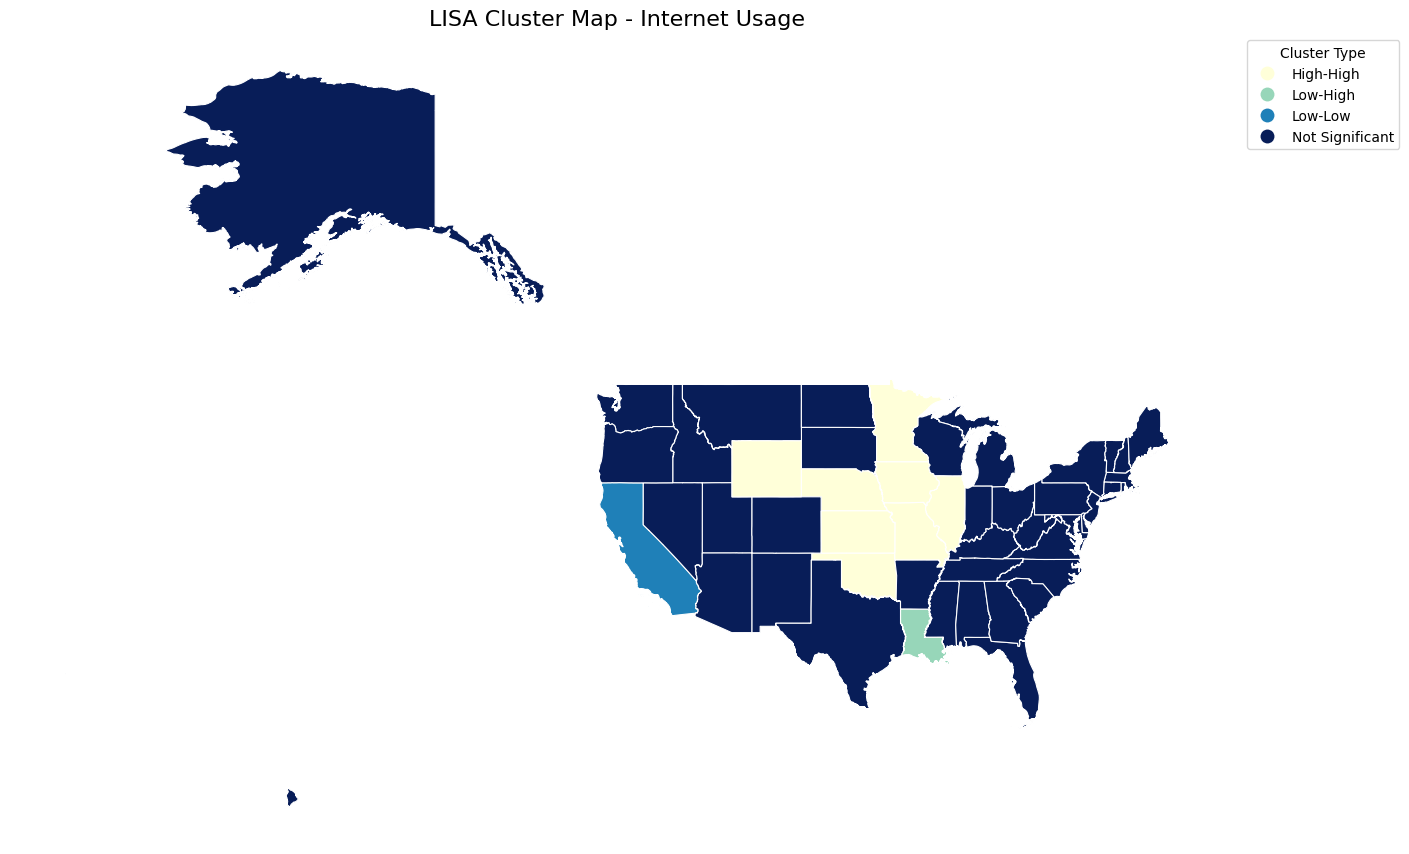

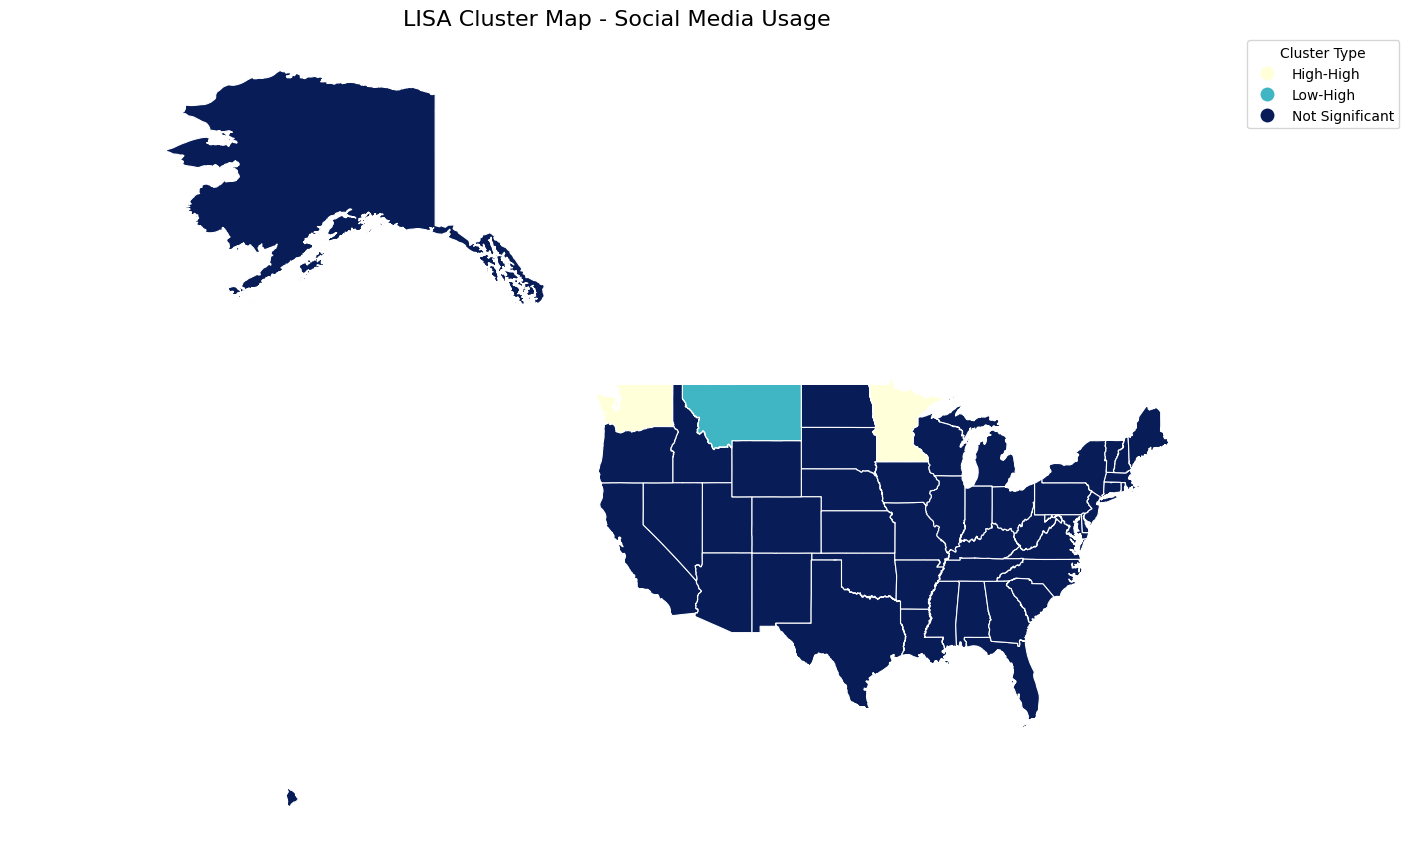

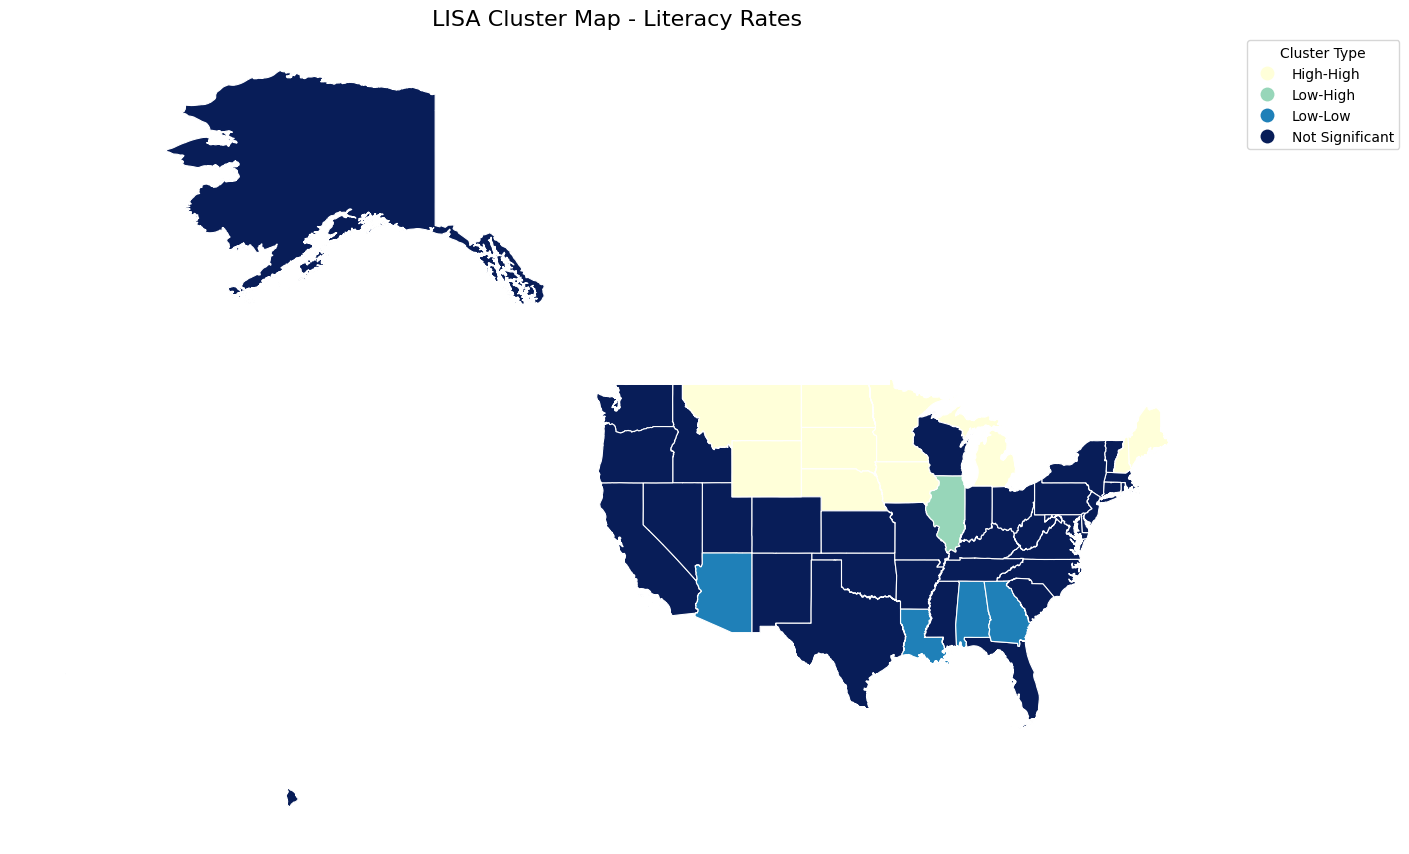

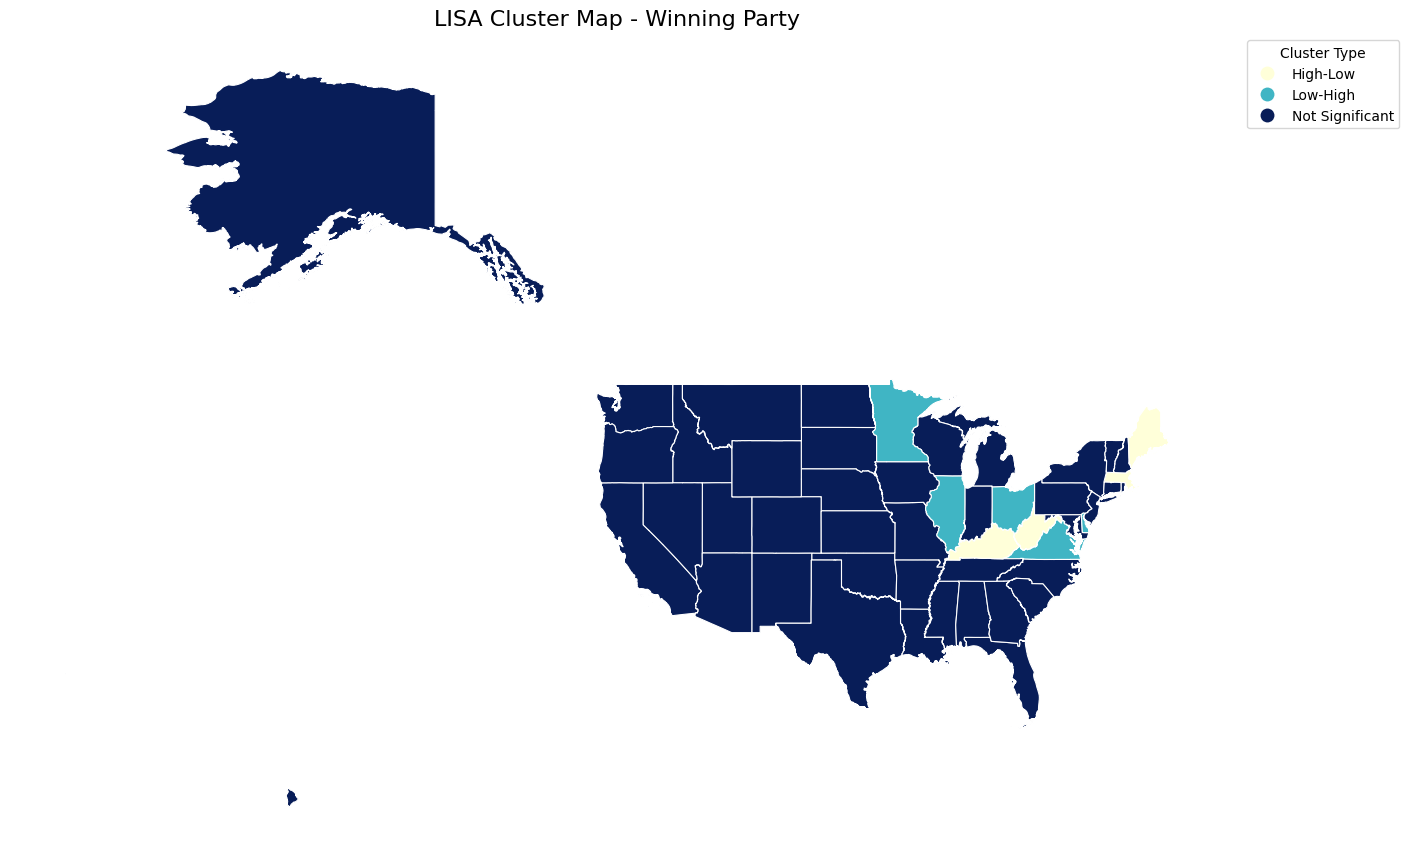

Optimization terminated successfully.
         Current function value: 0.663145
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     WinningParty_binary   No. Observations:                   50
Model:                           Logit   Df Residuals:                       47
Method:                            MLE   Df Model:                            2
Date:                 Mon, 21 Apr 2025   Pseudo R-squ.:                 -0.3252
Time:                         20:52:56   Log-Likelihood:                -33.157
converged:                        True   LL-Null:                       -25.020
Covariance Type:             nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
internet_z     0.4138      0.324      1.277      0.202      -0.221       1.049
social_z      -0.2916

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_23888\2303258884.py:86: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


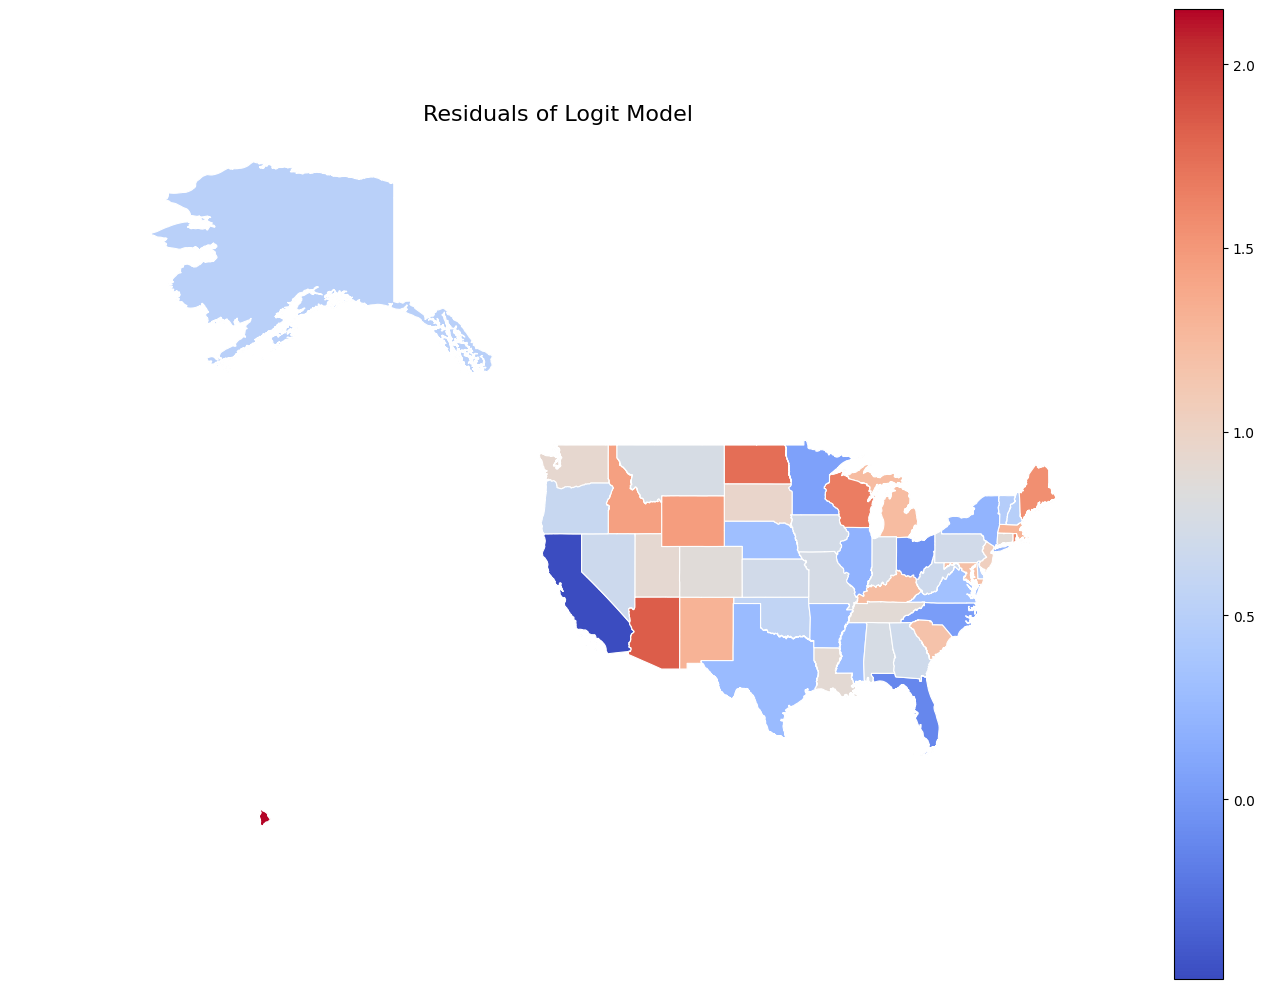

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_23888\2303258884.py:86: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


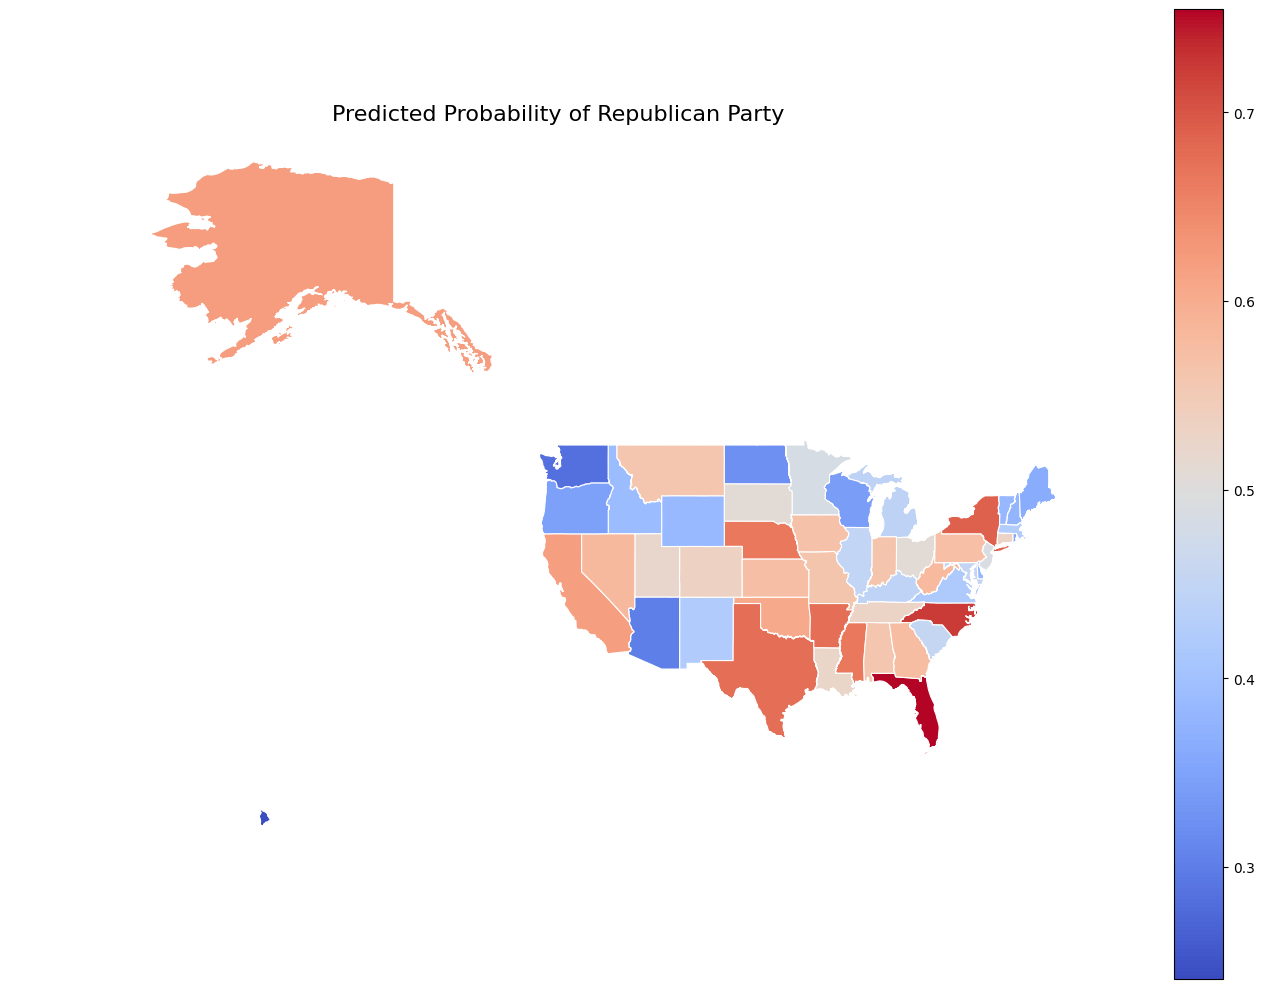

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_23888\2303258884.py:144: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.array([(pt.x, pt.y) for pt in gdf_clean.geometry.centroid])


Selected bandwidth for GWLR: 50.0
Model type                                                         Binomial
Number of observations:                                                  50
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                            45.186
Log-likelihood:                                                     -22.593
AIC:                                                                 53.186
AICc:                                                                54.074
BIC:                                                               -134.767
Percent deviance explained:                                           0.097
Adj. percent deviance explained:                                      0.038

Variable                              Est.         SE  t(Est/SE)    p-value
--------------------------

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_23888\2303258884.py:86: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


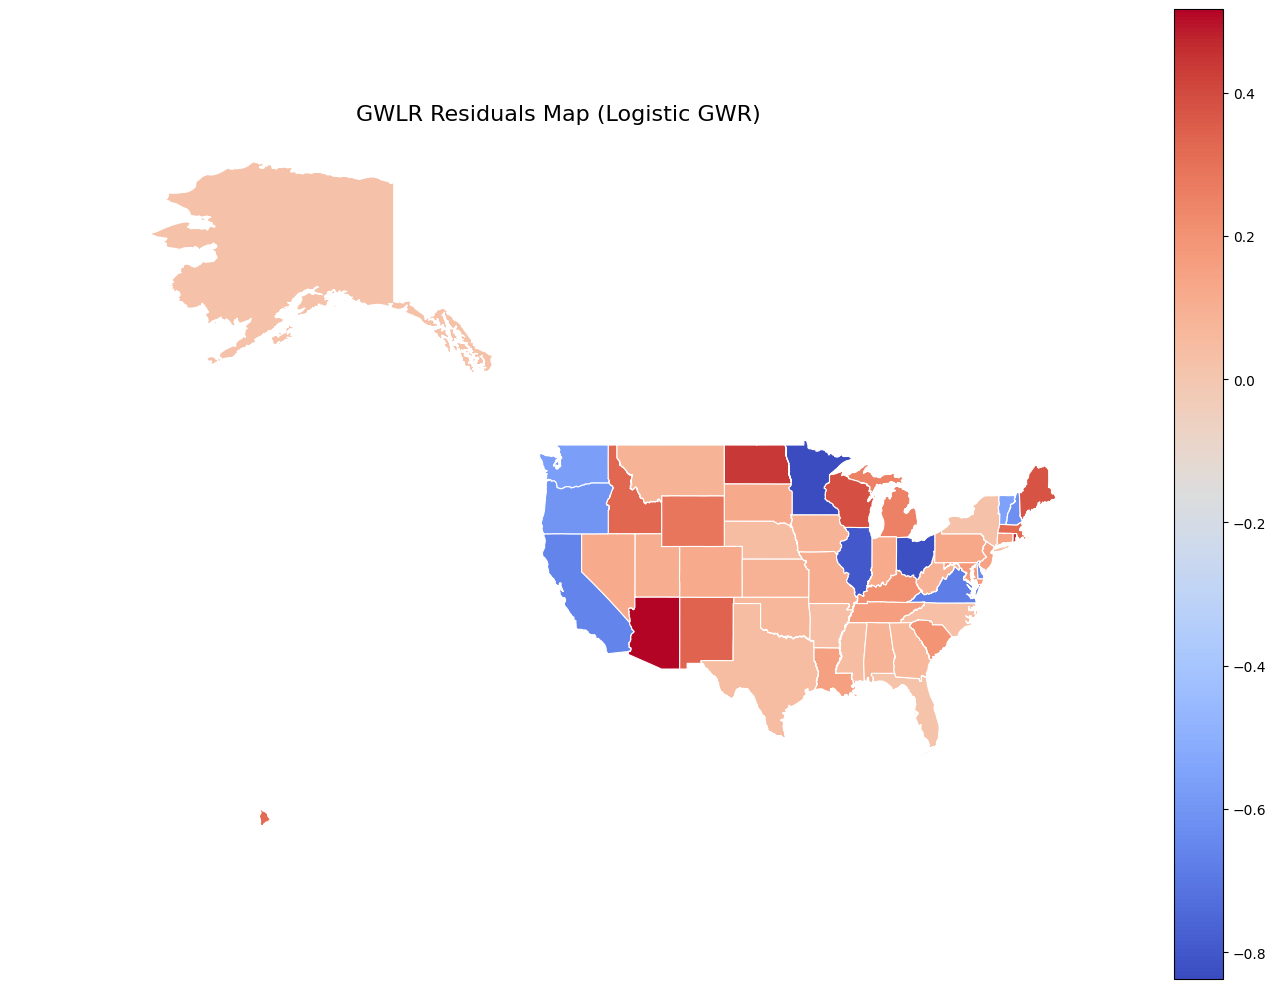

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_23888\2303258884.py:86: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


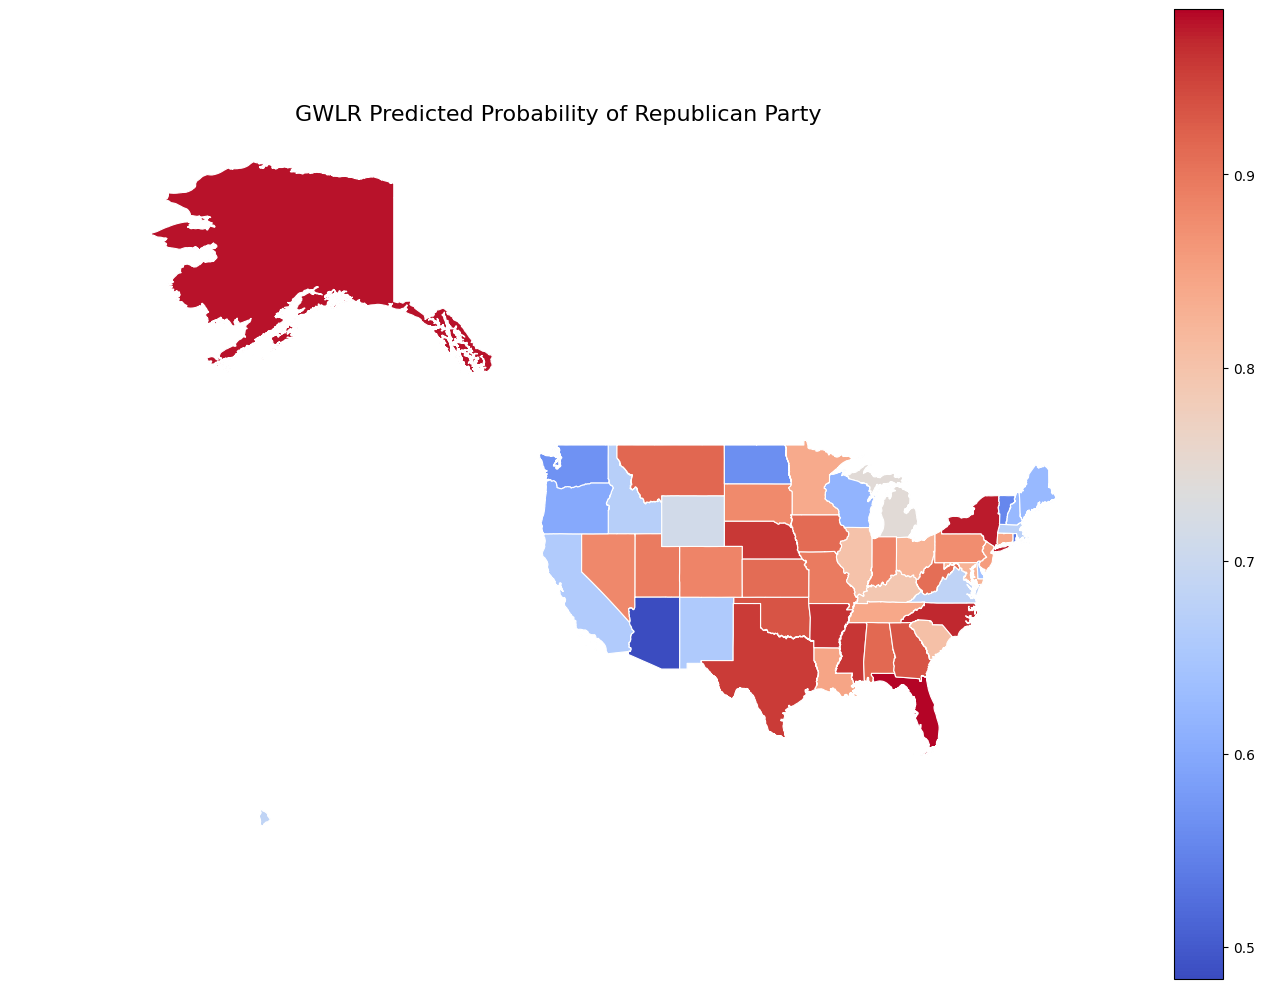

In [48]:
# --- 1. Import necessary packages ---
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from statsmodels.api import Logit
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import lag_spatial
from spglm.family import Binomial


# --- 2. Load Data ---
shapefile_path = r"C:\Users\Rhitwik\Downloads\US_States\US_States\US_STATES.shp"
csv_path = r"C:\Users\Rhitwik\Downloads\Geostats_Twitter_Final_Results.csv"

gdf = gpd.read_file(shapefile_path)
df = pd.read_csv(csv_path)

# Merge shapefile with CSV data on state name
gdf = gdf.merge(df, left_on="NAME", right_on="STATE_NAME")

# --- 3. Clean & Standardize ---
gdf["internet_z"] = (gdf["Internet_Usage_P"] - gdf["Internet_Usage_P"].mean()) / gdf["Internet_Usage_P"].std()
gdf["social_z"] = (gdf["Social_Media_Usage_P"] - gdf["Social_Media_Usage_P"].mean()) / gdf["Social_Media_Usage_P"].std()
gdf["literacy_z"] = (gdf["Literacy_Rates_P"] - gdf["Literacy_Rates_P"].mean()) / gdf["Literacy_Rates_P"].std()
gdf["WinningParty_binary"] = gdf["WinningParty"].apply(lambda x: 1 if x == "Republican" else 0)

gdf_clean = gdf.dropna(subset=["internet_z", "social_z", "literacy_z", "WinningParty_binary"]).copy()

# --- 4. Spatial Weights ---
w = Queen.from_dataframe(gdf_clean)
w.transform = 'r'

# --- 5. Moran's I (Global Spatial Autocorrelation) ---
def compute_morans_i(var, name):
    moran = Moran(var, w)
    print(f"Moran's I for {name}: {moran.I}, p-value: {moran.p_sim}")

compute_morans_i(gdf_clean["internet_z"], "Internet Usage")
compute_morans_i(gdf_clean["social_z"], "Social Media Usage")
compute_morans_i(gdf_clean["literacy_z"], "Literacy Rates")
compute_morans_i(gdf_clean["WinningParty_binary"], "Winning Party Binary")

# --- 6. LISA (Local Moran's I) ---
def compute_lisa(var, name):
    lisa = Moran_Local(var, w)
    print(f"LISA for {name}:")
    return lisa

lisa_internet = compute_lisa(gdf_clean["internet_z"], "Internet Usage")
lisa_social = compute_lisa(gdf_clean["social_z"], "Social Media Usage")
lisa_literacy = compute_lisa(gdf_clean["literacy_z"], "Literacy Rates")
lisa_winning_party = compute_lisa(gdf_clean["WinningParty_binary"], "Winning Party Binary")

def classify_lisa(gdf, var, lisa, var_mean):
    cluster = []
    for i in range(len(gdf)):
        if lisa.p_sim[i] < 0.05:
            if gdf[var].iloc[i] > var_mean and lisa.Is[i] > 0:
                cluster.append("High-High")
            elif gdf[var].iloc[i] < var_mean and lisa.Is[i] > 0:
                cluster.append("Low-Low")
            elif gdf[var].iloc[i] > var_mean and lisa.Is[i] < 0:
                cluster.append("High-Low")
            elif gdf[var].iloc[i] < var_mean and lisa.Is[i] < 0:
                cluster.append("Low-High")
            else:
                cluster.append("Not Significant")
        else:
            cluster.append("Not Significant")
    return cluster

gdf_clean["cluster_internet"] = classify_lisa(gdf_clean, "internet_z", lisa_internet, gdf_clean["internet_z"].mean())
gdf_clean["cluster_social"] = classify_lisa(gdf_clean, "social_z", lisa_social, gdf_clean["social_z"].mean())
gdf_clean["cluster_literacy"] = classify_lisa(gdf_clean, "literacy_z", lisa_literacy, gdf_clean["literacy_z"].mean())
gdf_clean["cluster_winning_party"] = classify_lisa(gdf_clean, "WinningParty_binary", lisa_winning_party, gdf_clean["WinningParty_binary"].mean())

# --- Plot and Export LISA Cluster Maps ---
def plot_and_export_map(df, column, title, filename, cmap="YlGnBu"):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    # Check dtype: if object -> categorical legend, else numeric
    if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):
        df.plot(
            column=column,
            cmap=cmap,
            legend=True,
            legend_kwds={'title': 'Cluster Type', 'bbox_to_anchor': (1.15, 1)},
            edgecolor='white',
            linewidth=0.8,
            ax=ax
        )
    else:
        df.plot(
            column=column,
            cmap=cmap,
            legend=True,
            edgecolor='white',
            linewidth=0.8,
            ax=ax
        )
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Export Maps for LISA Clusters
plot_and_export_map(gdf_clean, "cluster_internet", "LISA Cluster Map - Internet Usage", "LISA_Cluster_Internet.png")
plot_and_export_map(gdf_clean, "cluster_social", "LISA Cluster Map - Social Media Usage", "LISA_Cluster_Social.png")
plot_and_export_map(gdf_clean, "cluster_literacy", "LISA Cluster Map - Literacy Rates", "LISA_Cluster_Literacy.png")
plot_and_export_map(gdf_clean, "cluster_winning_party", "LISA Cluster Map - Winning Party", "LISA_Cluster_WinningParty.png")

# --- 7. Logit Model ---
X = gdf_clean[["internet_z", "social_z", "literacy_z"]].values
y = gdf_clean["WinningParty_binary"].values.reshape(-1, 1)

logit_model = Logit(gdf_clean["WinningParty_binary"], gdf_clean[["internet_z", "social_z", "literacy_z"]])
logit_results = logit_model.fit()
print(logit_results.summary())

# Predicted probabilities
gdf_clean["predicted_prob_republican"] = logit_results.predict()

# Residuals
logit_residuals = gdf_clean["WinningParty_binary"] - logit_results.fittedvalues
gdf_clean['logit_residuals'] = logit_residuals

# Moran's I for Logit Residuals
moran_logit_resid = Moran(logit_residuals.values, w)
print("Moran's I for Logit Residuals:", moran_logit_resid.I, "p-value:", moran_logit_resid.p_sim)

# Plot Residuals Map
plot_and_export_map(gdf_clean, 'logit_residuals', "Residuals of Logit Model", "Logit_Residuals_Map.png", cmap="coolwarm")

# Plot Predicted Probabilities Map
plot_and_export_map(gdf_clean, 'predicted_prob_republican', "Predicted Probability of Republican Party", "Predicted_Probability_Republican.png", cmap="coolwarm")

# --- 8. Geographically Weighted Logistic Regression (GWLR) ---
# 8.1. Prepare spatial coordinates (centroids) and data matrices
coords = np.array([(pt.x, pt.y) for pt in gdf_clean.geometry.centroid])
y_gw = gdf_clean["WinningParty_binary"].values.reshape((-1, 1))
# include constant in X
X_gw = sm.add_constant(gdf_clean[["internet_z", "social_z", "literacy_z"]]).values

# 8.2. Select optimal bandwidth for binomial GWLR
bw = Sel_BW(coords, y_gw, X_gw, family=Binomial()).search()
print(f"Selected bandwidth for GWLR: {bw}")

# 8.3. Fit the GWLR model
gwlr_model = GWR(coords, y_gw, X_gw, bw, family=Binomial())
gwlr_results = gwlr_model.fit()

# 8.4. Print GWLR summary
print(gwlr_results.summary())

# 8.5. Moran's I on GWLR residuals
gwlr_resids = gwlr_results.resid_response.flatten()
moran_gwlr = Moran(gwlr_resids, w)
print(f"Moran's I for GWLR residuals: {moran_gwlr.I:.4f}, p-value: {moran_gwlr.p_sim:.4f}")

# 8.6. Plot & export GWLR residuals map
gdf_clean["gwlr_residuals"] = gwlr_resids
plot_and_export_map(
    gdf_clean,
    "gwlr_residuals",
    "GWLR Residuals Map (Logistic GWR)",
    "GWLR_Residuals_Map.png",
    cmap="coolwarm"
)

# 8.7. Predicted probabilities from GWLR
gwlr_predicted_probabilities = gwlr_results.predy.flatten()

# Add to GeoDataFrame
gdf_clean["gwlr_predicted_prob_republican"] = gwlr_predicted_probabilities

# Plot predicted probabilities
plot_and_export_map(
    gdf_clean,
    "gwlr_predicted_prob_republican",
    "GWLR Predicted Probability of Republican Party",
    "GWLR_Predicted_Probability_Republican.png",
    cmap="coolwarm"
)

**Modified5** (5 Independents) **FINAL MODEL**

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\178124675.py:41: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_clean)
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 26, 38.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
Moran's I for Internet Usage: 0.1780089522249165, p-value: 0.025
Moran's I for Social Media Usage: -0.06721637751229495, p-value: 0.334
Moran's I for Literacy Rates: 0.4561276416654953, p-value: 0.002
Moran's I for Diversity Index: 0.39518927772923446, p-value: 0.001
Moran's I for Median Household Income: 0.2965279866817514, p-value: 0.004
Moran's I for Winning Party Binary: 0.010540674603174585, p-value: 0.355


C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\

LISA for Internet Usage:
LISA for Social Media Usage:
LISA for Literacy Rates:
LISA for Diversity Index:
LISA for Median Household Income:
LISA for Winning Party Binary:


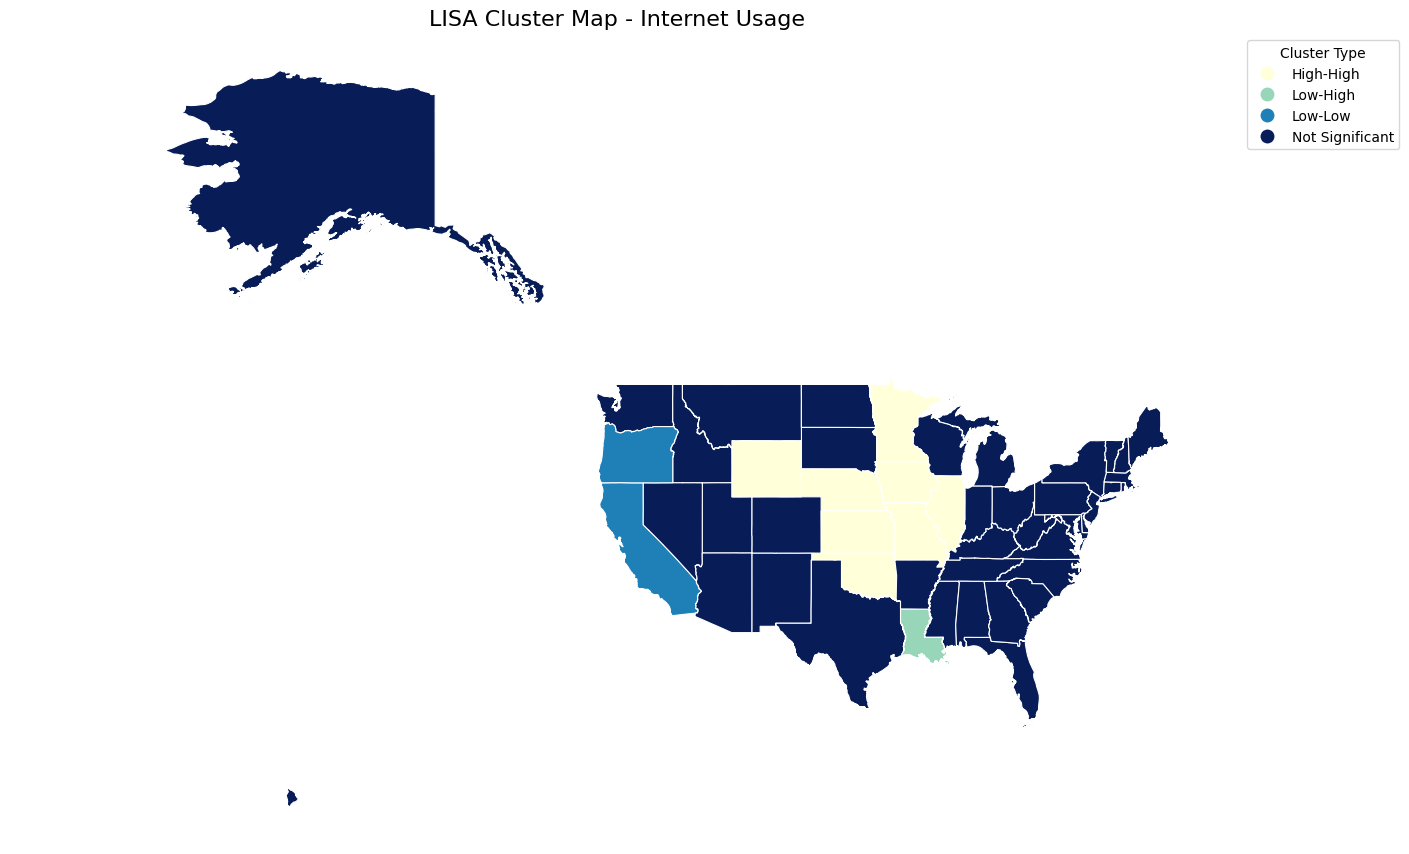

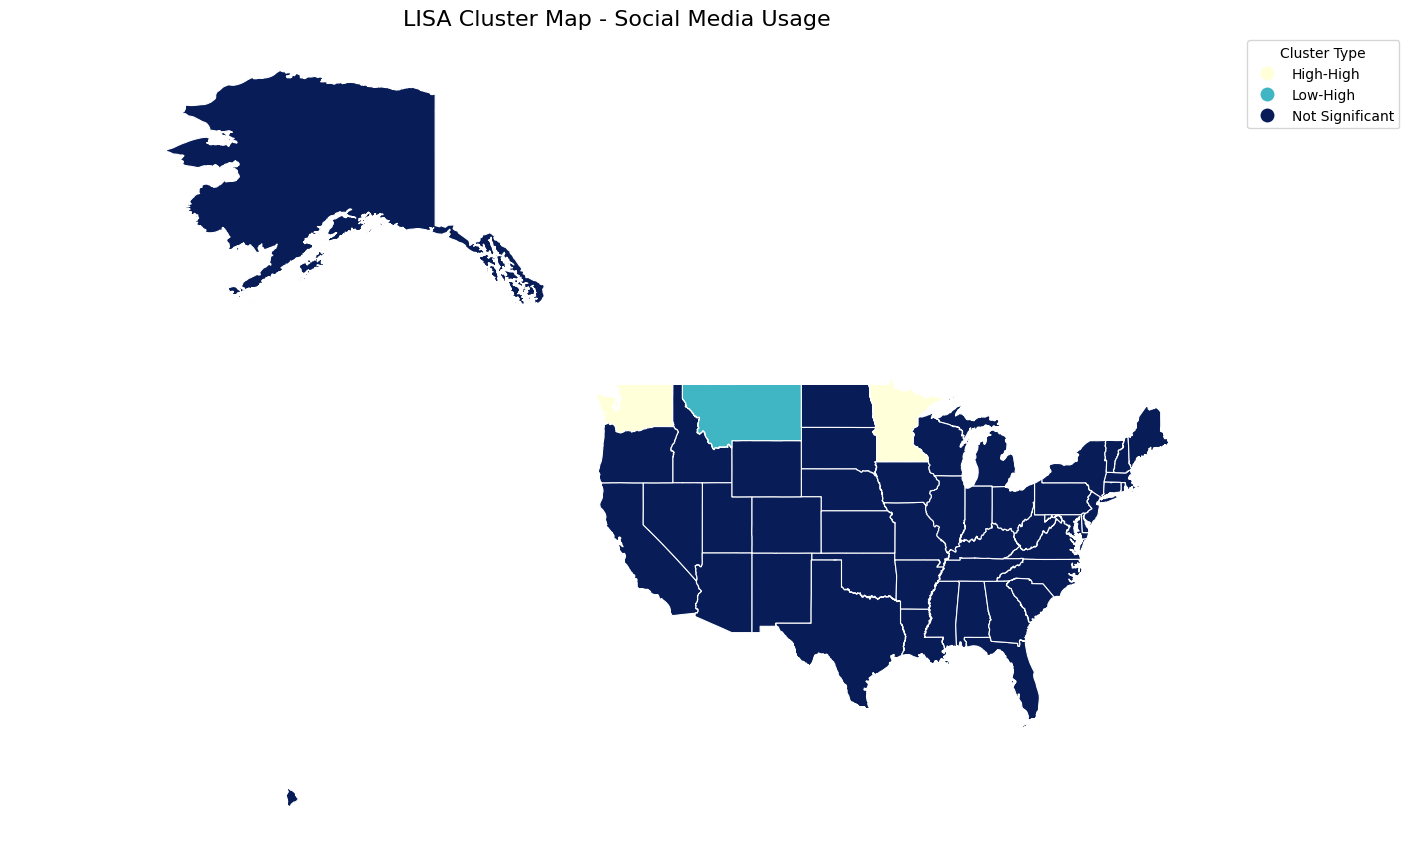

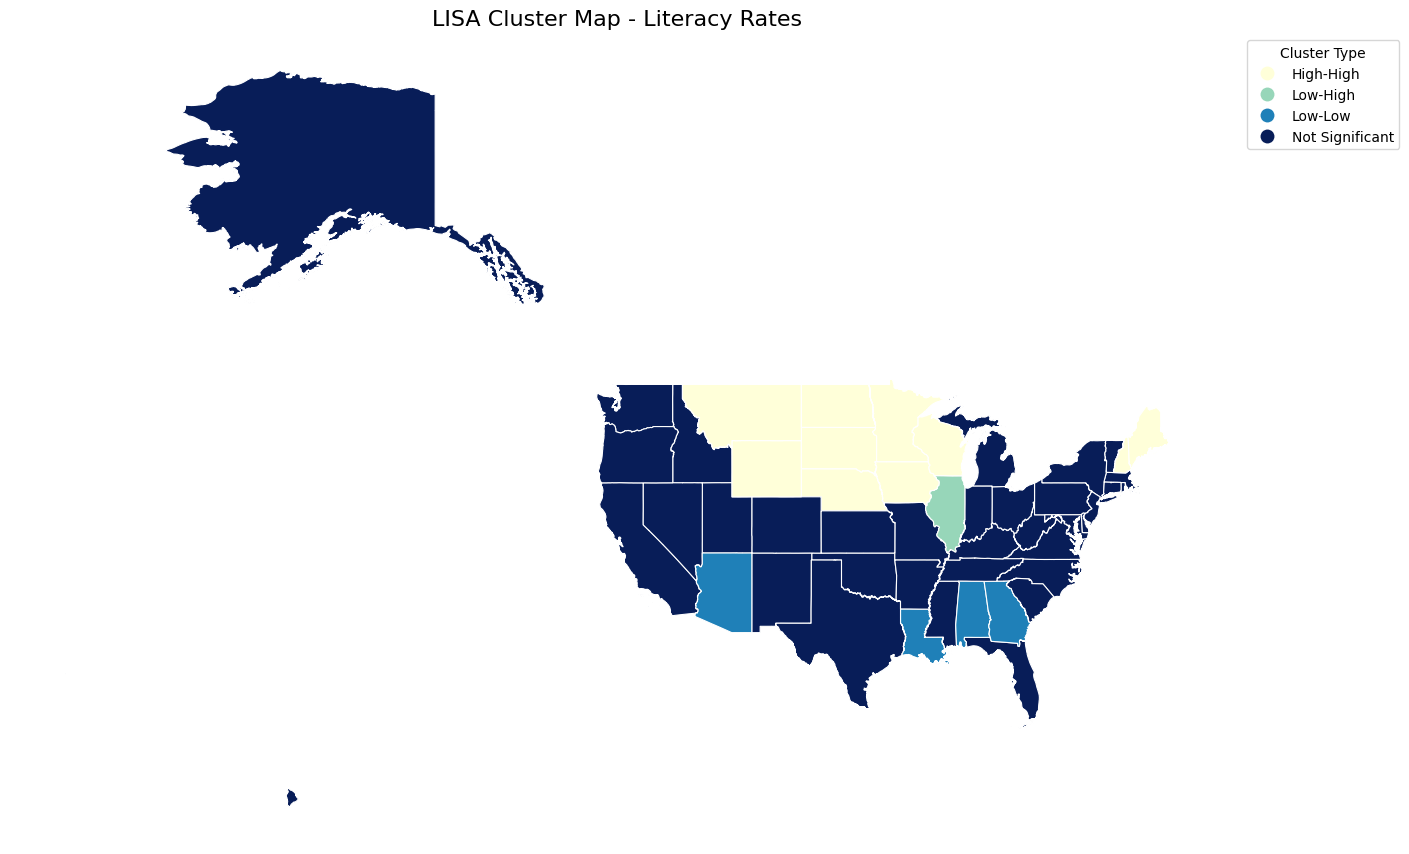

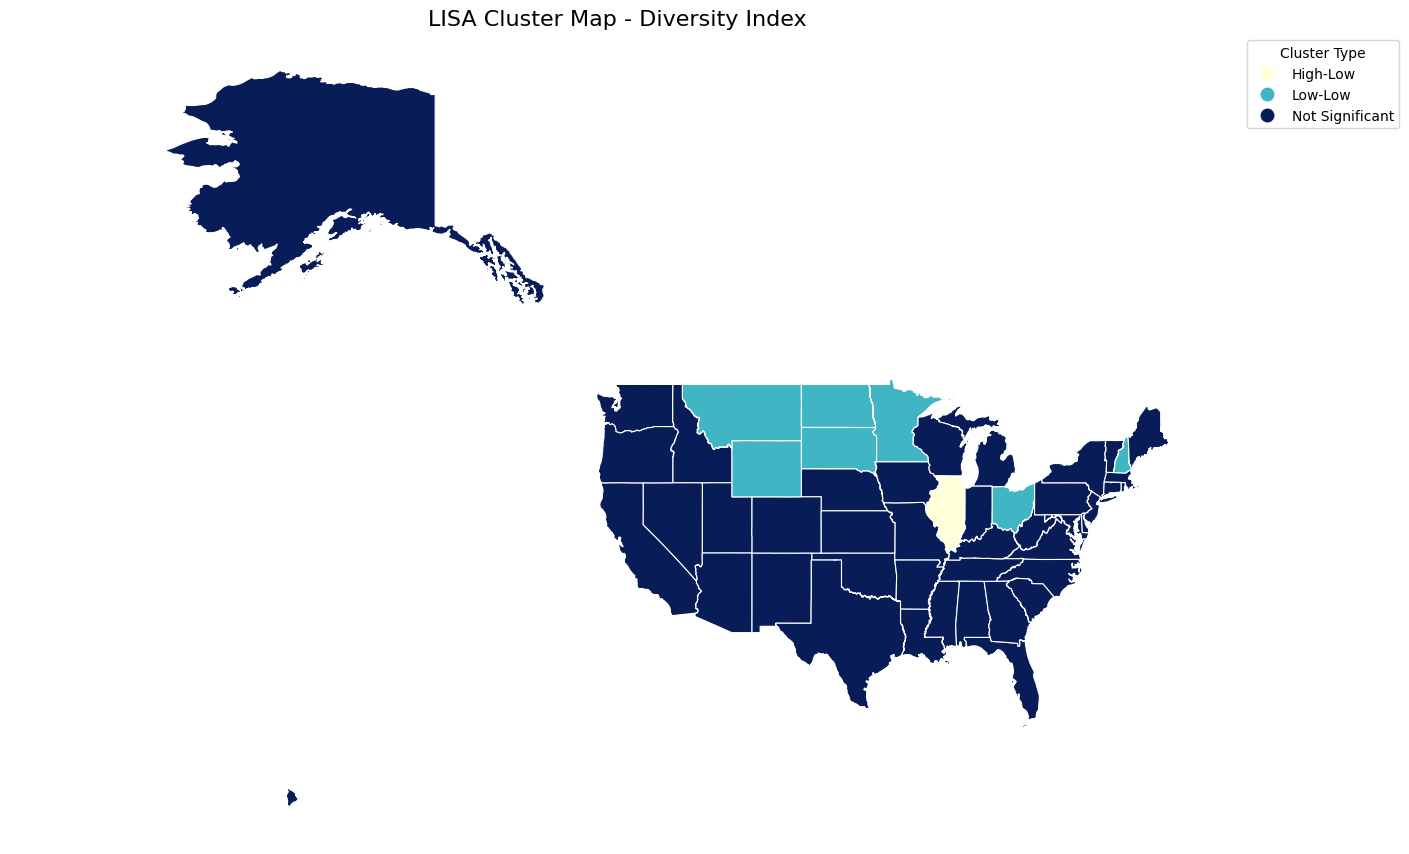

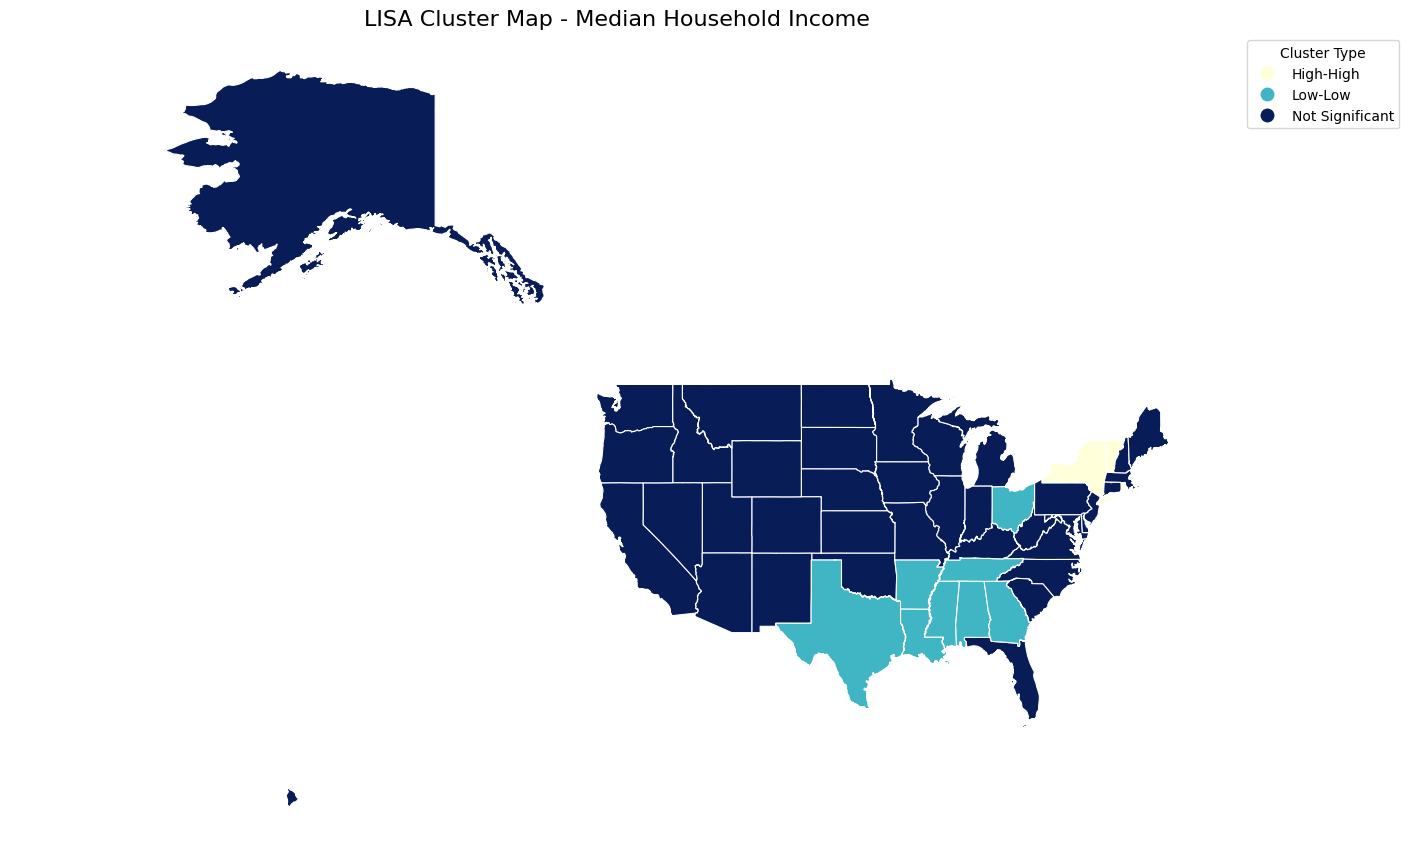

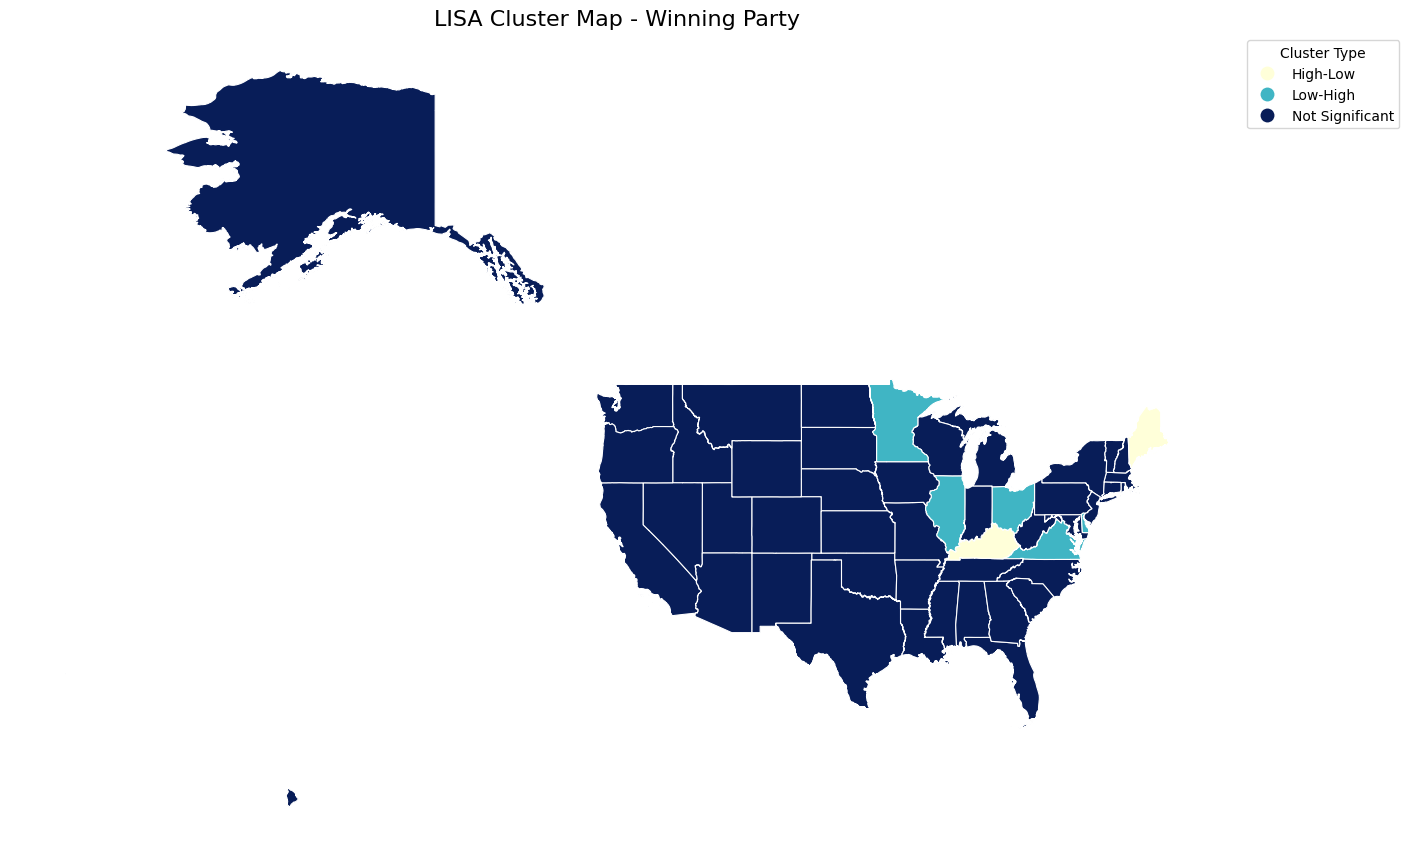

Optimization terminated successfully.
         Current function value: 0.634715
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     WinningParty_binary   No. Observations:                   50
Model:                           Logit   Df Residuals:                       45
Method:                            MLE   Df Model:                            4
Date:                 Wed, 23 Apr 2025   Pseudo R-squ.:                 -0.2684
Time:                         11:28:49   Log-Likelihood:                -31.736
converged:                        True   LL-Null:                       -25.020
Covariance Type:             nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
internet_z      0.3170      0.342      0.927      0.354      -0.353       0.987
social_z       -0.

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\178124675.py:97: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


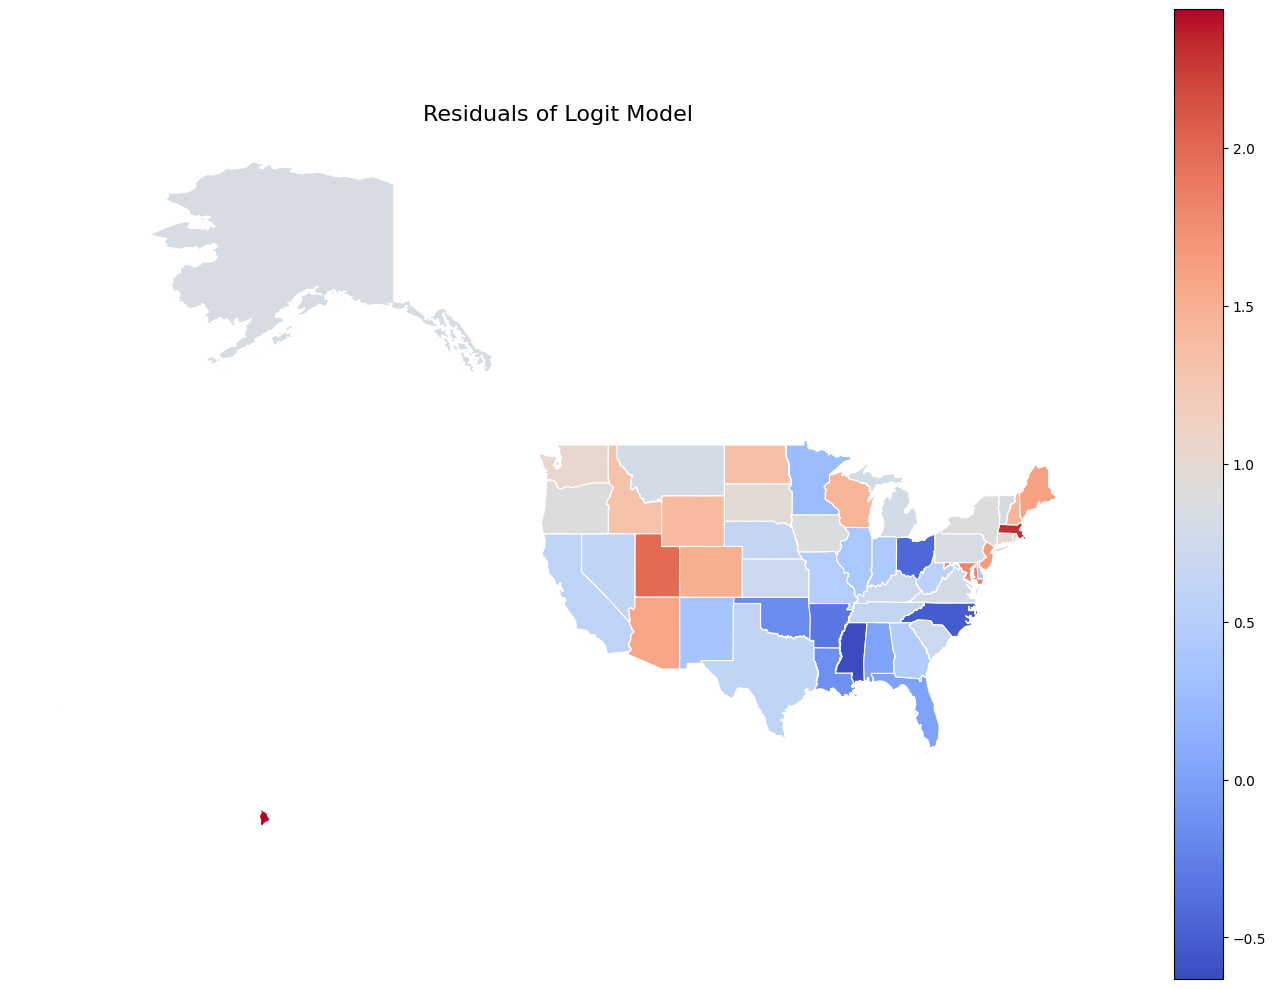

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\178124675.py:97: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


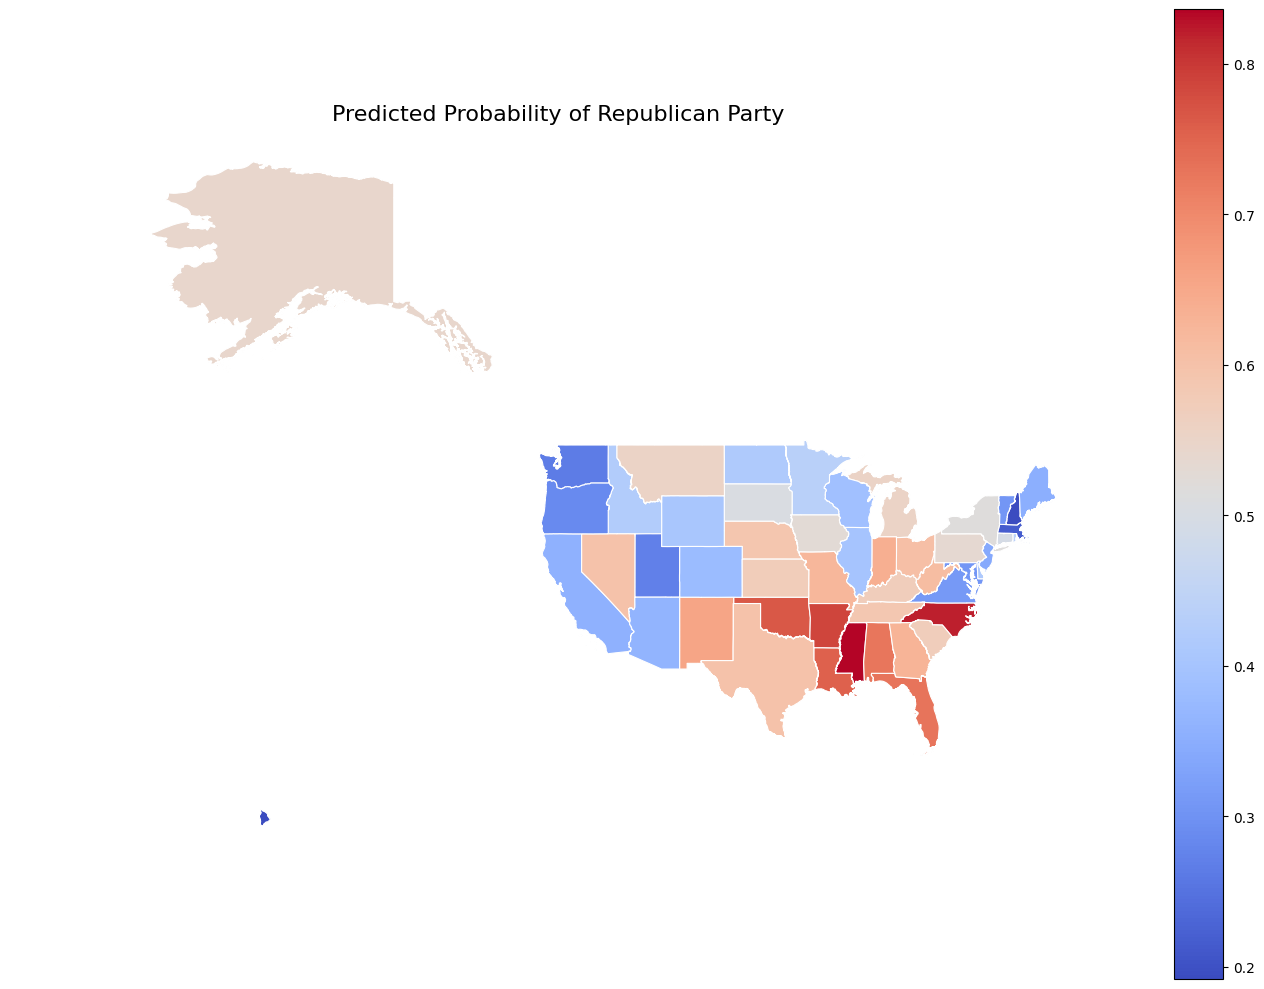

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\178124675.py:144: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.array([(pt.x, pt.y) for pt in gdf_clean.geometry.centroid])


Selected bandwidth for GWLR: 10


C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\spglm\family.py:944: RuntimeWarning: divide by zero encountered in divide
  (endog * np.log(mu / (1 - mu) + 1e-200) + np.log(1 - mu)) * freq_weights
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\spglm\family.py:944: RuntimeWarning: divide by zero encountered in log
  (endog * np.log(mu / (1 - mu) + 1e-200) + np.log(1 - mu)) * freq_weights
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\spglm\family.py:944: RuntimeWarning: invalid value encountered in add
  (endog * np.log(mu / (1 - mu) + 1e-200) + np.log(1 - mu)) * freq_weights
C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\178124675.py:97: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


Model type                                                         Binomial
Number of observations:                                                  50
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                            40.082
Log-likelihood:                                                     -20.041
AIC:                                                                 52.082
AICc:                                                                54.035
BIC:                                                               -132.047
Percent deviance explained:                                           0.199
Adj. percent deviance explained:                                      0.108

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

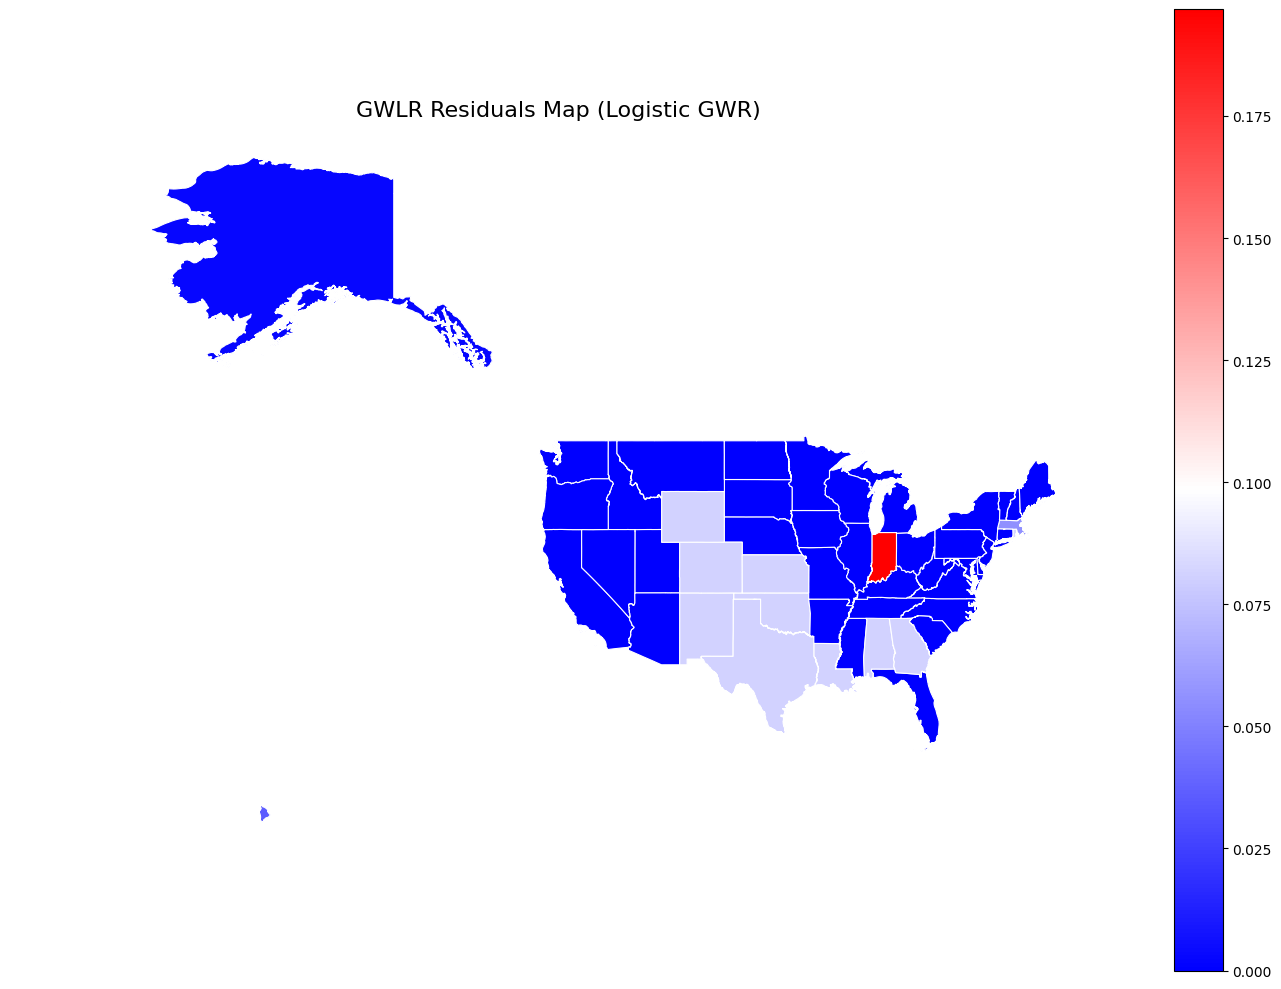

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\178124675.py:97: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


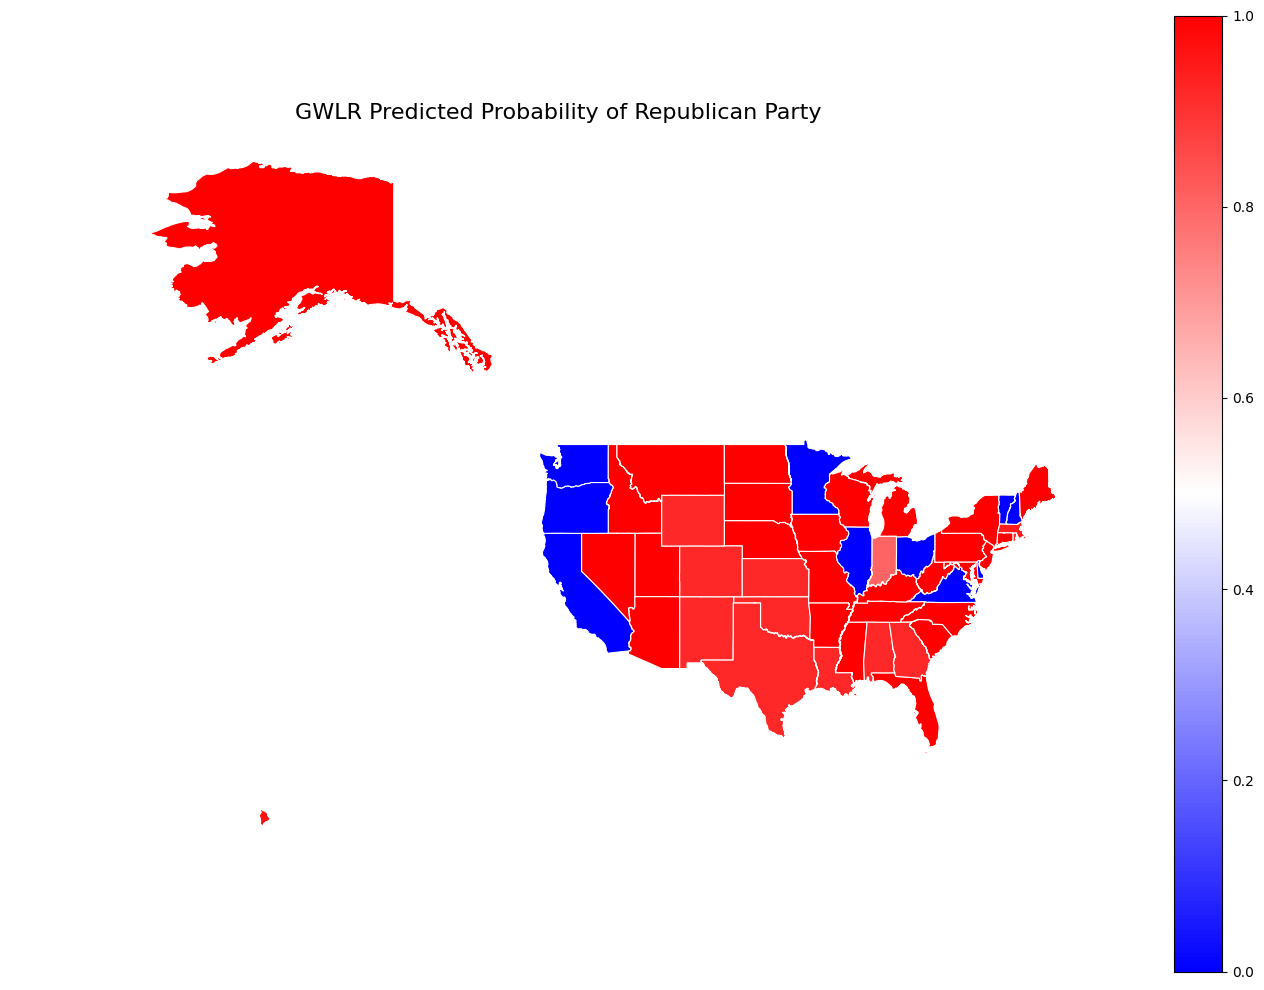

In [1]:
# --- 1. Import necessary packages ---
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from statsmodels.api import Logit
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import lag_spatial
from spglm.family import Binomial
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap


# --- 2. Load Data ---
shapefile_path = r"C:\Users\Rhitwik\Downloads\US_States\US_States\US_STATES.shp"
csv_path = r"C:\Users\Rhitwik\Downloads\Geostats_Twitter_Final_Results.csv"

gdf = gpd.read_file(shapefile_path)
df = pd.read_csv(csv_path)

# Merge shapefile with CSV data on state name
gdf = gdf.merge(df, left_on="NAME", right_on="STATE_NAME")

# --- 3. Clean & Standardize ---
# Z-score standardization for all independent variables
gdf["internet_z"] = (gdf["Internet_Usage_P"] - gdf["Internet_Usage_P"].mean()) / gdf["Internet_Usage_P"].std()
gdf["social_z"] = (gdf["Social_Media_Usage_P"] - gdf["Social_Media_Usage_P"].mean()) / gdf["Social_Media_Usage_P"].std()
gdf["literacy_z"] = (gdf["Literacy_Rates_P"] - gdf["Literacy_Rates_P"].mean()) / gdf["Literacy_Rates_P"].std()
gdf["diversity_z"] = (gdf["Diversity_Index_P"] - gdf["Diversity_Index_P"].mean()) / gdf["Diversity_Index_P"].std()
gdf["income_z"] = (gdf["Median_Household_Income"] - gdf["Median_Household_Income"].mean()) / gdf["Median_Household_Income"].std()

gdf["WinningParty_binary"] = gdf["WinningParty"].apply(lambda x: 1 if x == "Republican" else 0)

gdf_clean = gdf.dropna(subset=["internet_z", "social_z", "literacy_z", "diversity_z", "income_z", "WinningParty_binary"]).copy()

# --- 4. Spatial Weights ---
w = Queen.from_dataframe(gdf_clean)
w.transform = 'r'

# --- 5. Moran's I (Global Spatial Autocorrelation) ---
def compute_morans_i(var, name):
    moran = Moran(var, w)
    print(f"Moran's I for {name}: {moran.I}, p-value: {moran.p_sim}")

compute_morans_i(gdf_clean["internet_z"], "Internet Usage")
compute_morans_i(gdf_clean["social_z"], "Social Media Usage")
compute_morans_i(gdf_clean["literacy_z"], "Literacy Rates")
compute_morans_i(gdf_clean["diversity_z"], "Diversity Index")
compute_morans_i(gdf_clean["income_z"], "Median Household Income")
compute_morans_i(gdf_clean["WinningParty_binary"], "Winning Party Binary")

# --- 6. LISA (Local Moran's I) ---
def compute_lisa(var, name):
    lisa = Moran_Local(var, w)
    print(f"LISA for {name}:")
    return lisa

lisa_internet = compute_lisa(gdf_clean["internet_z"], "Internet Usage")
lisa_social = compute_lisa(gdf_clean["social_z"], "Social Media Usage")
lisa_literacy = compute_lisa(gdf_clean["literacy_z"], "Literacy Rates")
lisa_diversity = compute_lisa(gdf_clean["diversity_z"], "Diversity Index")
lisa_income = compute_lisa(gdf_clean["income_z"], "Median Household Income")
lisa_winning_party = compute_lisa(gdf_clean["WinningParty_binary"], "Winning Party Binary")

def classify_lisa(gdf, var, lisa, var_mean):
    cluster = []
    for i in range(len(gdf)):
        if lisa.p_sim[i] < 0.05:
            if gdf[var].iloc[i] > var_mean and lisa.Is[i] > 0:
                cluster.append("High-High")
            elif gdf[var].iloc[i] < var_mean and lisa.Is[i] > 0:
                cluster.append("Low-Low")
            elif gdf[var].iloc[i] > var_mean and lisa.Is[i] < 0:
                cluster.append("High-Low")
            elif gdf[var].iloc[i] < var_mean and lisa.Is[i] < 0:
                cluster.append("Low-High")
            else:
                cluster.append("Not Significant")
        else:
            cluster.append("Not Significant")
    return cluster

gdf_clean["cluster_internet"] = classify_lisa(gdf_clean, "internet_z", lisa_internet, gdf_clean["internet_z"].mean())
gdf_clean["cluster_social"] = classify_lisa(gdf_clean, "social_z", lisa_social, gdf_clean["social_z"].mean())
gdf_clean["cluster_literacy"] = classify_lisa(gdf_clean, "literacy_z", lisa_literacy, gdf_clean["literacy_z"].mean())
gdf_clean["cluster_diversity"] = classify_lisa(gdf_clean, "diversity_z", lisa_diversity, gdf_clean["diversity_z"].mean())
gdf_clean["cluster_income"] = classify_lisa(gdf_clean, "income_z", lisa_income, gdf_clean["income_z"].mean())
gdf_clean["cluster_winning_party"] = classify_lisa(gdf_clean, "WinningParty_binary", lisa_winning_party, gdf_clean["WinningParty_binary"].mean())

# --- Plot and Export LISA Cluster Maps ---
def plot_and_export_map(df, column, title, filename, cmap="YlGnBu"):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):
        df.plot(column=column, cmap=cmap, legend=True,
                legend_kwds={'title': 'Cluster Type', 'bbox_to_anchor': (1.15, 1)},
                edgecolor='white', linewidth=0.8, ax=ax)
    else:
        df.plot(column=column, cmap=cmap, legend=True,
                edgecolor='white', linewidth=0.8, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Export Maps for LISA Clusters
plot_and_export_map(gdf_clean, "cluster_internet", "LISA Cluster Map - Internet Usage", "LISA_Cluster_Internet.png")
plot_and_export_map(gdf_clean, "cluster_social", "LISA Cluster Map - Social Media Usage", "LISA_Cluster_Social.png")
plot_and_export_map(gdf_clean, "cluster_literacy", "LISA Cluster Map - Literacy Rates", "LISA_Cluster_Literacy.png")
plot_and_export_map(gdf_clean, "cluster_diversity", "LISA Cluster Map - Diversity Index", "LISA_Cluster_Diversity.png")
plot_and_export_map(gdf_clean, "cluster_income", "LISA Cluster Map - Median Household Income", "LISA_Cluster_Income.png")
plot_and_export_map(gdf_clean, "cluster_winning_party", "LISA Cluster Map - Winning Party", "LISA_Cluster_WinningParty.png")

# --- 7. Logit Model ---
X = gdf_clean[["internet_z", "social_z", "literacy_z", "diversity_z", "income_z"]].values
y = gdf_clean["WinningParty_binary"].values.reshape(-1, 1)

logit_model = Logit(gdf_clean["WinningParty_binary"], gdf_clean[["internet_z", "social_z", "literacy_z", "diversity_z", "income_z"]])
logit_results = logit_model.fit()
print(logit_results.summary())

# Predicted probabilities
gdf_clean["predicted_prob_republican"] = logit_results.predict()

# Residuals
logit_residuals = gdf_clean["WinningParty_binary"] - logit_results.fittedvalues
gdf_clean['logit_residuals'] = logit_residuals

# Moran's I for Logit Residuals
moran_logit_resid = Moran(logit_residuals.values, w)
print("Moran's I for Logit Residuals:", moran_logit_resid.I, "p-value:", moran_logit_resid.p_sim)

# Plot Residuals Map
plot_and_export_map(gdf_clean, 'logit_residuals', "Residuals of Logit Model", "Logit_Residuals_Map.png", cmap="coolwarm")

# Plot Predicted Probabilities Map
plot_and_export_map(gdf_clean, 'predicted_prob_republican', "Predicted Probability of Republican Party", "Predicted_Probability_Republican.png", cmap="coolwarm")

# --- 8. Geographically Weighted Logistic Regression (GWLR) ---
coords = np.array([(pt.x, pt.y) for pt in gdf_clean.geometry.centroid])
y_gw = gdf_clean["WinningParty_binary"].values.reshape((-1, 1))
X_gw = sm.add_constant(gdf_clean[["internet_z", "social_z", "literacy_z", "diversity_z", "income_z"]]).values

bw = 15 #Sel_BW(coords, y_gw, X_gw, family=Binomial()).search()
print(f"Selected bandwidth for GWLR: {bw}")

gwlr_model = GWR(coords, y_gw, X_gw, bw, family=Binomial())
gwlr_results = gwlr_model.fit()

print(gwlr_results.summary())

gwlr_resids = gwlr_results.resid_response.flatten()
moran_gwlr = Moran(gwlr_resids, w)
print(f"Moran's I for GWLR residuals: {moran_gwlr.I:.4f}, p-value: {moran_gwlr.p_sim:.4f}")

gdf_clean["gwlr_residuals"] = gwlr_resids
plot_and_export_map(
    gdf_clean,
    "gwlr_residuals",
    "GWLR Residuals Map (Logistic GWR)",
    "GWLR_Residuals_Map.png",
    cmap="bwr"
)

gwlr_predicted_probabilities = gwlr_results.predy.flatten()
gdf_clean["gwlr_predicted_prob_republican"] = gwlr_predicted_probabilities

plot_and_export_map(
    gdf_clean,
    "gwlr_predicted_prob_republican",
    "GWLR Predicted Probability of Republican Party",
    "GWLR_Predicted_Probability_Republican.png",
    cmap="bwr"
)

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\1418704383.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.array([(pt.x, pt.y) for pt in gdf_clean.geometry.centroid])


Selected bandwidth for GWLR: 15


C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\spglm\family.py:944: RuntimeWarning: divide by zero encountered in divide
  (endog * np.log(mu / (1 - mu) + 1e-200) + np.log(1 - mu)) * freq_weights
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\spglm\family.py:944: RuntimeWarning: divide by zero encountered in log
  (endog * np.log(mu / (1 - mu) + 1e-200) + np.log(1 - mu)) * freq_weights
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\spglm\family.py:944: RuntimeWarning: invalid value encountered in add
  (endog * np.log(mu / (1 - mu) + 1e-200) + np.log(1 - mu)) * freq_weights


Model type                                                         Binomial
Number of observations:                                                  50
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                            40.082
Log-likelihood:                                                     -20.041
AIC:                                                                 52.082
AICc:                                                                54.035
BIC:                                                               -132.047
Percent deviance explained:                                           0.199
Adj. percent deviance explained:                                      0.108

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\2412370906.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


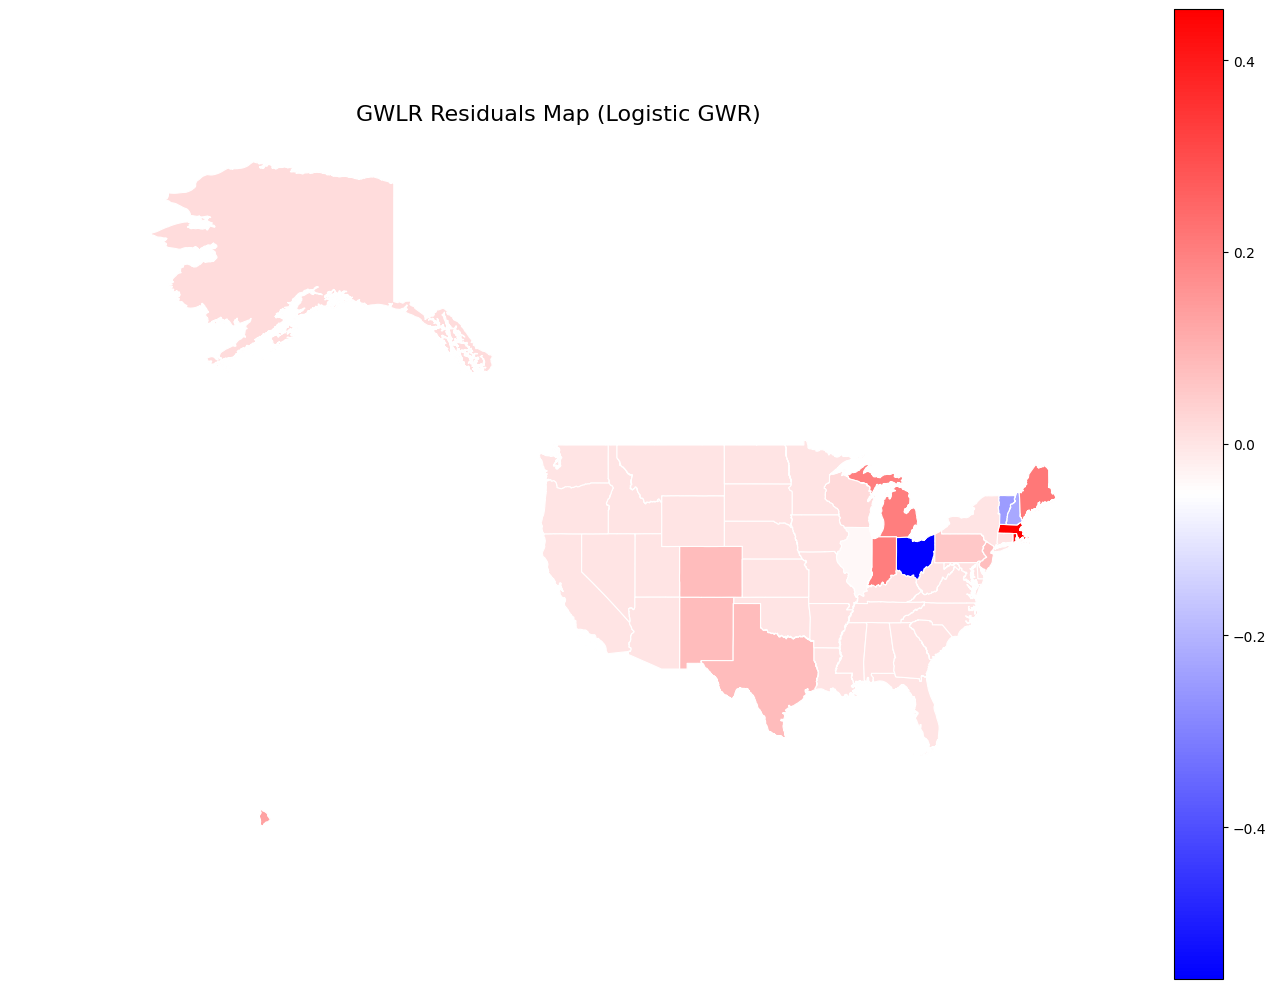

In [9]:
# GWLR Separately 
# --- 8. Geographically Weighted Logistic Regression (GWLR) ---
coords = np.array([(pt.x, pt.y) for pt in gdf_clean.geometry.centroid])
y_gw = gdf_clean["WinningParty_binary"].values.reshape((-1, 1))
X_gw = sm.add_constant(gdf_clean[["internet_z", "social_z", "literacy_z", "diversity_z", "income_z"]]).values

bw = 15 #Sel_BW(coords, y_gw, X_gw, family=Binomial()).search()
print(f"Selected bandwidth for GWLR: {bw}")

gwlr_model = GWR(coords, y_gw, X_gw, bw, family=Binomial())
gwlr_results = gwlr_model.fit()

print(gwlr_results.summary())

gwlr_resids = gwlr_results.resid_response.flatten()
moran_gwlr = Moran(gwlr_resids, w)
print(f"Moran's I for GWLR residuals: {moran_gwlr.I:.4f}, p-value: {moran_gwlr.p_sim:.4f}")

gdf_clean["gwlr_residuals"] = gwlr_resids
plot_and_export_map(
    gdf_clean,
    "gwlr_residuals",
    "GWLR Residuals Map (Logistic GWR)",
    "GWLR_Residuals_Map.png",
    cmap="bwr"
)

                             OLS Regression Results                            
Dep. Variable:     WinningParty_binary   R-squared:                       0.174
Model:                             OLS   Adj. R-squared:                  0.080
Method:                  Least Squares   F-statistic:                     1.850
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):              0.123
Time:                         13:02:52   Log-Likelihood:                -20.362
No. Observations:                   50   AIC:                             52.72
Df Residuals:                       44   BIC:                             64.20
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8000      0.055     14

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\2412370906.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


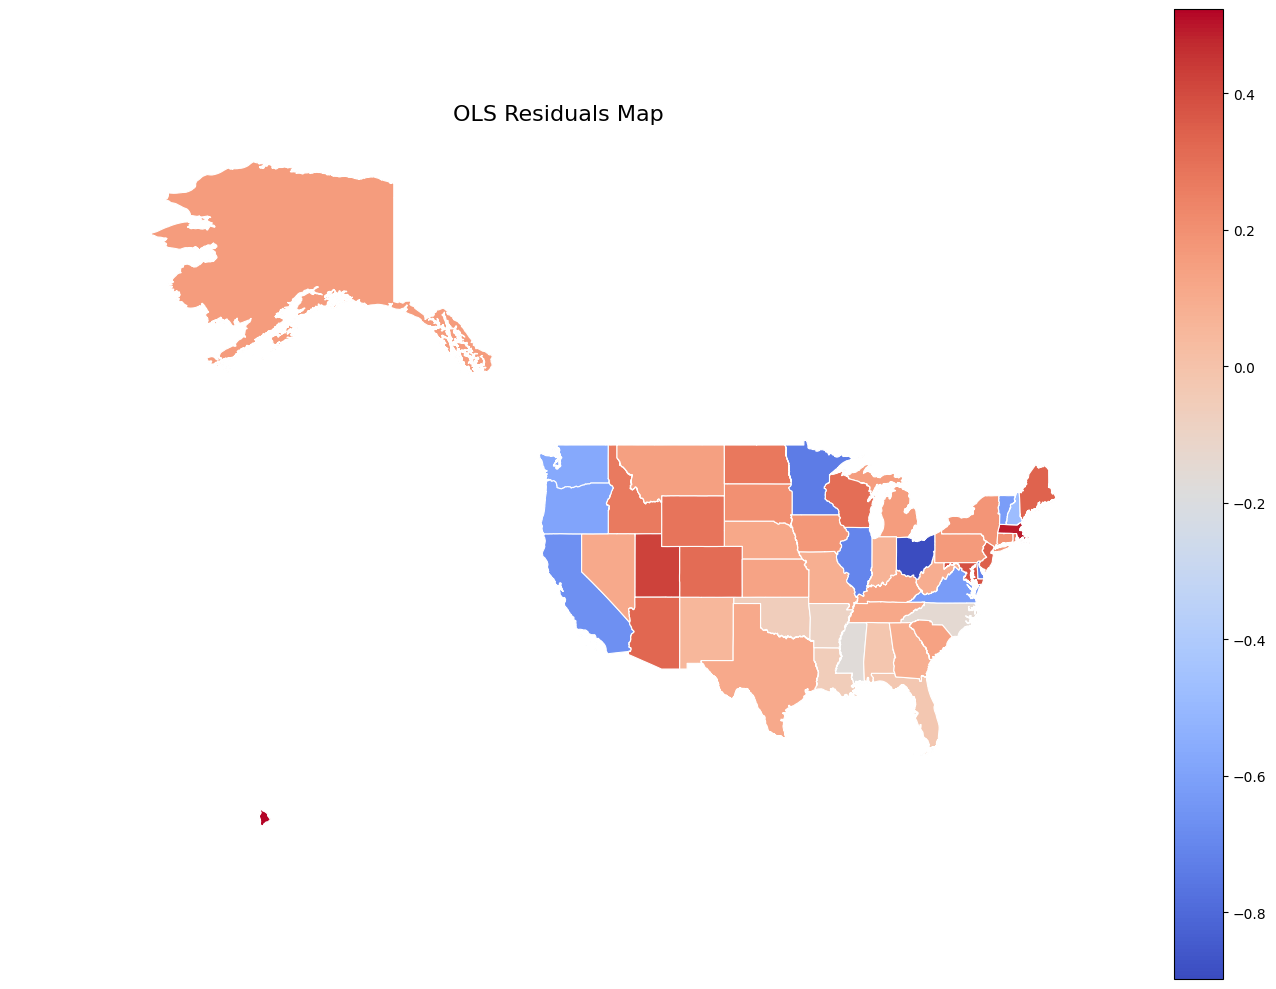

In [8]:
from statsmodels.api import OLS
# --- 5. OLS Model ---
# Prepare the independent variables and dependent variable for OLS
X_ols = gdf_clean[["internet_z", "social_z", "literacy_z", "diversity_z", "income_z"]]
X_ols = sm.add_constant(X_ols)  # Adding intercept term
y_ols = gdf_clean["WinningParty_binary"]

# Fit OLS model
ols_model = OLS(y_ols, X_ols)
ols_results = ols_model.fit()

# Display OLS results
print(ols_results.summary())

# --- 6. OLS Residuals ---
# Get residuals from OLS model
ols_residuals = ols_results.resid
gdf_clean['ols_residuals'] = ols_residuals

# --- 7. Moran's I for OLS Residuals ---
moran_ols_resid = Moran(ols_residuals.values, w)
print(f"Moran's I for OLS residuals: {moran_ols_resid.I:.4f}, p-value: {moran_ols_resid.p_sim:.4f}")

# --- 8. Plot OLS Residuals Map ---
def plot_and_export_map(df, column, title, filename, cmap="coolwarm"):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):
        df.plot(column=column, cmap=cmap, legend=True,
                legend_kwds={'title': 'Residuals', 'bbox_to_anchor': (1.15, 1)},
                edgecolor='white', linewidth=0.8, ax=ax)
    else:
        df.plot(column=column, cmap=cmap, legend=True,
                edgecolor='white', linewidth=0.8, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot residuals map for OLS
plot_and_export_map(gdf_clean, "ols_residuals", "OLS Residuals Map", "OLS_Residuals_Map.png", cmap="coolwarm")

In [7]:
# --- Collinearity Check between Internet_Usage_P and Social_Media_Usage ---

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Pearson Correlation
corr_value = gdf_clean[["Internet_Usage_P", "Social_Media_Usage_P"]].corr().iloc[0, 1]
print(f"Pearson Correlation Coefficient: {corr_value:.3f}")

# Step 2: Variance Inflation Factor (VIF)
# Prepare the data
X_collinear = gdf_clean[["Internet_Usage_P", "Social_Media_Usage_P"]].dropna()
X_collinear = sm.add_constant(X_collinear)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_collinear.columns
vif_data["VIF"] = [variance_inflation_factor(X_collinear.values, i) for i in range(X_collinear.shape[1])]

print("\nVariance Inflation Factor (VIF):")
print(vif_data)

Pearson Correlation Coefficient: 0.138

Variance Inflation Factor (VIF):
               Variable          VIF
0                 const  1059.261177
1      Internet_Usage_P     1.019492
2  Social_Media_Usage_P     1.019492


**Clustering of Residuals**

C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


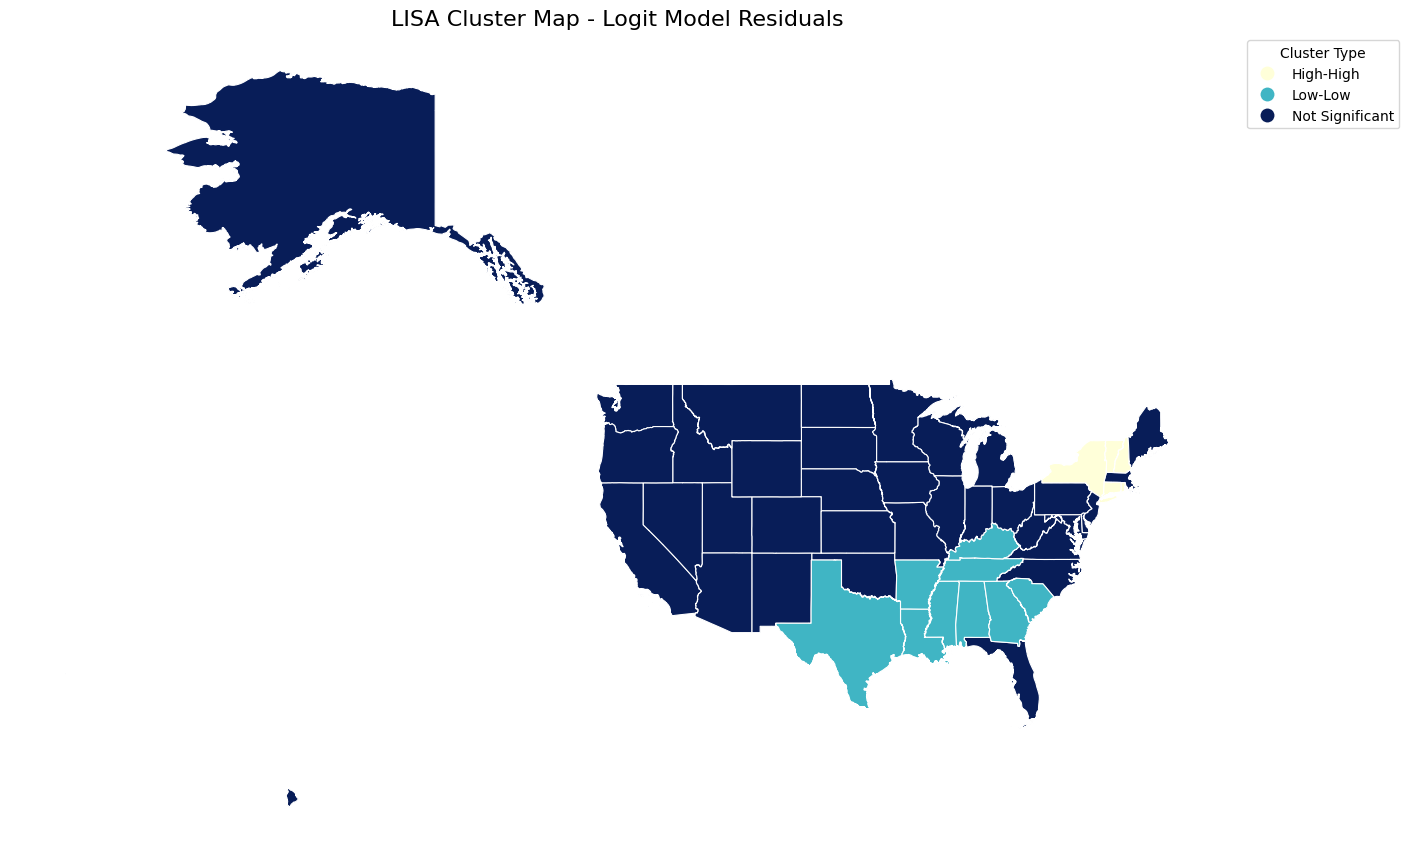

C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


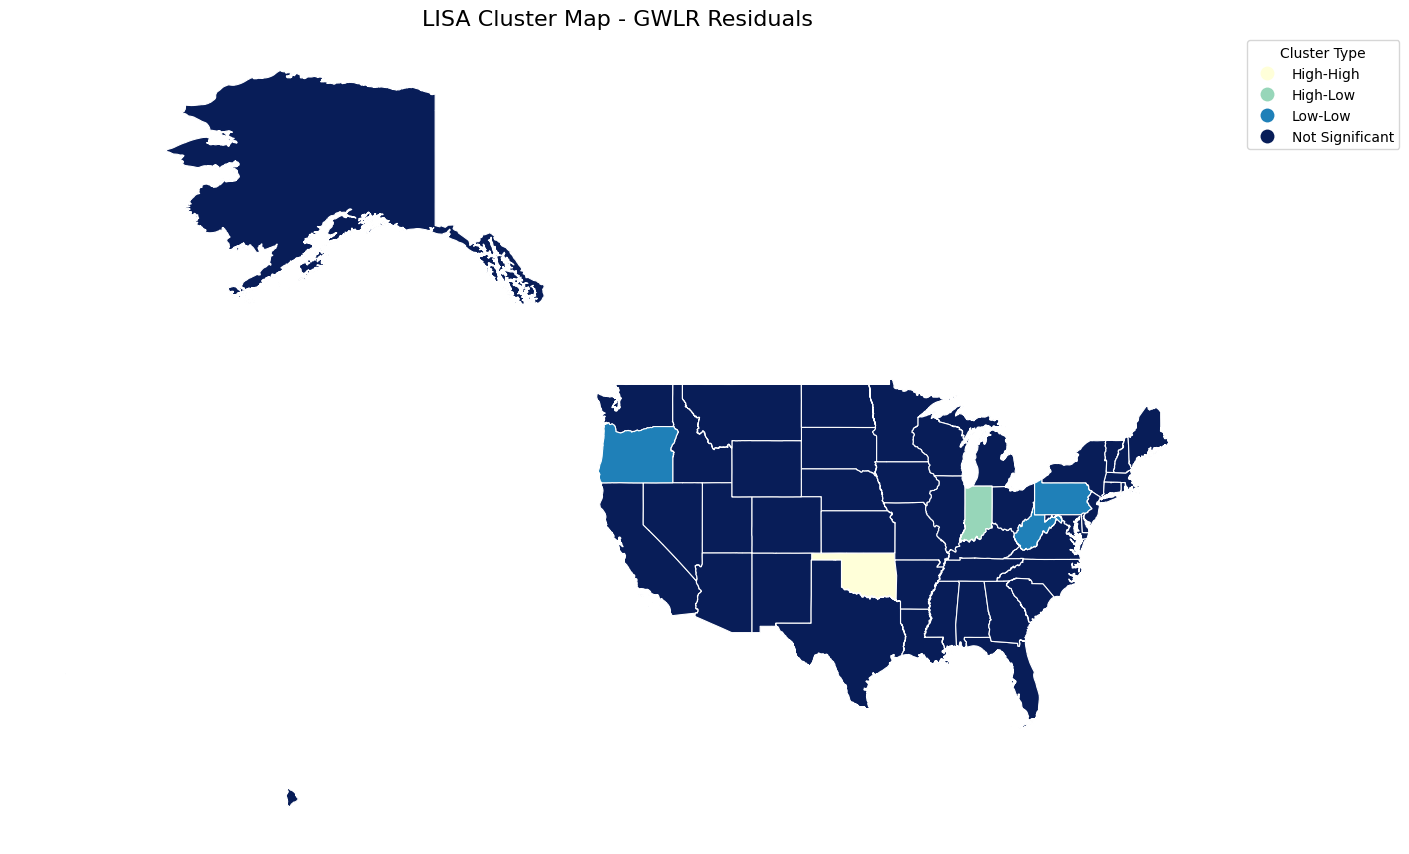

In [4]:
# --- LISA for Logit Residuals ---
lisa_logit_resid = Moran_Local(logit_residuals.values, w)
gdf_clean["cluster_logit_resid"] = classify_lisa(gdf_clean, "logit_residuals", lisa_logit_resid, gdf_clean["logit_residuals"].mean())

plot_and_export_map(
    gdf_clean,
    "cluster_logit_resid",
    "LISA Cluster Map - Logit Model Residuals",
    "LISA_Cluster_Logit_Residuals.png"
)

# --- LISA for GWLR Residuals ---
lisa_gwlr_resid = Moran_Local(gwlr_resids, w)
gdf_clean["cluster_gwlr_resid"] = classify_lisa(gdf_clean, "gwlr_residuals", lisa_gwlr_resid, gdf_clean["gwlr_residuals"].mean())

plot_and_export_map(
    gdf_clean,
    "cluster_gwlr_resid",
    "LISA Cluster Map - GWLR Residuals",
    "LISA_Cluster_GWLR_Residuals.png"
)


**Exporting**

In [6]:
# --- 9. Export Enhanced GeoDataFrame to Shapefiles ---

# Create output folder path if it doesn't exist
import os
output_folder = r"C:\Users\Rhitwik\Downloads\Geostats_Results_Shapefiles"
os.makedirs(output_folder, exist_ok=True)

# Export the GeoDataFrame with all new LISA clusters, predictions, and residuals
output_shapefile = os.path.join(output_folder, "US_States_LISA_Results.shp")
gdf_clean.to_file(output_shapefile)

print(f"Shapefile exported successfully to: {output_shapefile}")

C:\Users\Rhitwik\AppData\Local\Temp\ipykernel_22984\2817092947.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_clean.to_file(output_shapefile)


Shapefile exported successfully to: C:\Users\Rhitwik\Downloads\Geostats_Results_Shapefiles\US_States_LISA_Results.shp


C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'CENTROIDX_x' to 'CENTROIDX_'
  ogr_write(
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'CENTROIDY_x' to 'CENTROIDY_'
  ogr_write(
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'WinningParty' to 'WinningPar'
  ogr_write(
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'PartyWonOriginal' to 'PartyWonOr'
  ogr_write(
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Internet_Usage_P' to 'Internet_U'
  ogr_write(
C:\Users\Rhitwik\anaconda3\envs\New_Fixed_Env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalize